# Initial Filtering of INEGI Data (notebook Fer)

Definición AGEB Urbana:

* Área Geoestadística Básica Urbana: AGEB URBANA
Se define como la extensión territorial ocupada por un conjunto de manzanas que generalmente son de 1
a 50, perfectamente delimitadas por calles, avenidas, andadores o cualquier otro rasgo de fácil
identificación en el terreno y cuyo uso del suelo sea principalmente habitacional, industrial, de servicios,
comercial, etc. Este tipo de AGEB se asigna en áreas geográficas de localidades que tengan una
población igual o mayor a **2,500 habitantes**, o bien que sea cabecera municipal independientemente del
número de habitantes de acuerdo al último Censo General o Conteo Nacional de Población y Vivienda. 

In [2]:
import pandas as pd
import zipfile
from zipfile import ZipFile
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import stats as st

## Censo de Población y Vivienda 2020

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
df = pd.read_csv("/Users/fernandogutierrez/Desktop/Berkeley/Cyplan 257/Project/Final project submission /GitHub Repo/data/Censo_2020_CDMX.zip", compression = "zip")

Initial cleaning:
* Las AGEBS 0000 son información agregada de la CDMX: la vamos a sacar de df y la vamos a poner en CDMX_df para tener accesible información agregada
* En NOM_LOC vamos a quitar información agregada 

In [5]:
list(set(df["NOM_LOC"]))

['San Andrés Mixquic',
 'Tláhuac',
 'San Miguel Ajusco',
 'Total del municipio',
 'Parres (El Guarda)',
 'San Pablo Oztotepec',
 'La Ciénega',
 'San Nicolás Tetelco',
 'Benito Juárez',
 'Azcapotzalco',
 'Venustiano Carranza',
 'Álvaro Obregón',
 'San Bartolomé Xicomulco',
 'San Pedro Atocpan',
 'San Juan Ixtayopan',
 'Lomas de Tepemecatl',
 'San Lorenzo Acopilco',
 'Santa Ana Tlacotenco',
 'Coyoacán',
 'Tlalpan',
 'Cuajimalpa de Morelos',
 'San Antonio Tecómitl',
 'Xochimilco',
 'Cuauhtémoc',
 'Total AGEB urbana',
 'Miguel Hidalgo',
 'San Francisco Tecoxpa',
 'San Miguel Topilejo',
 'La Magdalena Contreras',
 'Villa Milpa Alta',
 'Total de la entidad',
 'San Lorenzo Tlacoyucan',
 'Santa Catarina Yecahuitzotl',
 'San Salvador Cuauhtenco',
 'Gustavo A. Madero',
 'Iztacalco',
 'Iztapalapa',
 'Total de la localidad urbana']

In [6]:
NOM_LOC_agregada = ["Total de la localidad urbana",
                  "Total de la entidad",
                  "Total AGEB urbana",
                  "Total del municipio"]

In [7]:
CDMX_df = df[df["AGEB"]== "0000"]
CDMX_df.head()

,ENTIDAD,NOM_ENT,MUN,NOM_MUN,LOC,NOM_LOC,AGEB,MZA,POBTOT,POBFEM,...,VPH_TELEF,VPH_CEL,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC
0,9,Ciudad de México,0,Total de la entidad Ciudad de México,0,Total de la entidad,0000,0,9209944,4805017,...,1898265,2536523,2084156,1290811,957162,568827,46172,77272,561128,10528
1,9,Ciudad de México,2,Azcapotzalco,0,Total del municipio,0000,0,432205,227255,...,96128,123961,105899,66399,50965,31801,1661,2869,22687,322
2,9,Ciudad de México,2,Azcapotzalco,1,Total de la localidad urbana,0000,0,432205,227255,...,96128,123961,105899,66399,50965,31801,1661,2869,22687,322
3375,9,Ciudad de México,3,Coyoacán,0,Total del municipio,0000,0,614447,325337,...,145013,179280,157908,101660,80413,44991,2893,3506,27008,443
3376,9,Ciudad de México,3,Coyoacán,1,Total de la localidad urbana,0000,0,614447,325337,...,145013,179280,157908,101660,80413,44991,2893,3506,27008,443


In [8]:
print("Shape: ",df.shape)
print("Unique AGEBs before eliminating 0000 and Totales: ",len(list(set(df["AGEB"]))))
print("AGEBs == 0000: ",len(df[df["AGEB"]=="0000"]))
print("NOM_LOC in NOM_LOC_agregada: ",len(df[df["NOM_LOC"].isin(NOM_LOC_agregada)]))

Shape:  (68941, 230)
Unique AGEBs before eliminating 0000 and Totales:  1953
AGEBs == 0000:  52
NOM_LOC in NOM_LOC_agregada:  2485


In [9]:
#Tenemos que quitar los AGEBS donde son 0000 porque hablan de totales de municipios, localidades, etc
df = df.drop(df.index[[df["AGEB"] == "0000"]])

#Tenemos que quitar los que NOM_LOC incluye información agregada a nivel localidad urbana, entidad, ageb o municipio para evitar double counting: este es el total de la AGEB
df = df.drop(df[df["NOM_LOC"].isin(NOM_LOC_agregada)].index)

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexes/base.py:5377: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


In [10]:
print("Shape after eliminating 0000 and Total AGEB urbana: ", df.shape)
print("Unique AGEBs after eliminating 0000: ",len(list(set(df["AGEB"]))))
print("AGEBs == 0000: ",len(df[df["AGEB"]=="0000"]))
print("NOM_LOC in NOM_LOC_agregada: ",len(df[df["NOM_LOC"]=="Total AGEB urbana"]))

Shape after eliminating 0000 and Total AGEB urbana:  (66456, 230)
Unique AGEBs after eliminating 0000:  1952
AGEBs == 0000:  0
NOM_LOC in NOM_LOC_agregada:  0


### Columnas importantes del diccionario de datos:

* 1
  * Clave de entidad federativa 
    * ENTIDAD

* 2
  * Nombre oficial de la entidad federativa
    * NOM_ENT

* 3
  * Clave de municipio o demarcación territorial
    * MUN

* 4
  * Nombre oficial del municipio o demarcaciín territorial en el caso de la CDMX
    * NOM_MUN

* 5
  * Codigo de identifica a la localidad al interior de cada muncipio o demarcación territorial conforme al Marco Geoestadístico
    * LOC

* 6 
  * Nombre con el que se reconoce a la Localidad
    * NOM_LOC
  
* 7 
  * Clave que identifica al AGEB urbana, al interior de una localidad, de acuerdo con la desagregación del Marco Geoestadístico.
    * AGEB
  
* 8
  * Clave que identifica a la manzana, al interior de una AGEB, de acuerdo a la desagregación del Marco Geoestadístico
    * MZA
  
* 9 
  * Total de personas que residen habitualmente en el país, la entidad federativa, el municipio o la demarcación territorial y la localidad. Incluye la estimación del número de personas en viviendas particulares sin información de ocupantes. Incluye a la población que no especificó su edad.
    * POBTOT 

* 10
  * Total de mujeres que residen habitualmente en el país, la entidad federativa, el municipio o la demarcación territorial y la localidad. 
    * POBFEM

* 11
  * Total de hombres que residen habitualmente en el país, la entidad federativa, el municipio o la demarcación territorial y la localidad.
    * POBMAS

* 135 
  * Población de 12 años y más económicamente activa
    * PEA

* 138
  * Personas de 12 a 130 años de edad pensionadas o jubiladas; estudiantes; dedicadas a los quehaceres del hogar; están incapacitadas permanentemente para trabajar; o no trabajan.
    * PE_INAC

* 141
  * Personas de 12 a 130 años de edad que trabajaron o que no trabajaron, pero sí tenían trabajo en la semana de referencia
    * POCUPADA

* 144
  * Personas de 12 a 130 años de edad que no tenían trabajo, pero buscaron trabajo en la semana de referencia
    * PDESOCUP

* 173
  * Viviendas particulares habitadas de cualquier clase. Excluye a las viviendas particulares sin información de ocupantes.
    * VIVPAR_HAB


* 202
  * Viviendas particulares habitadas que no disponen de automóvil o camioneta ni de motocicleta o motoneta
    * VPH_NDACMM

* 207
  * Viviendas particulares habitadas que disponen de automóvil o camioneta
    * VPH_AUTOM

* 208
  * Viviendas particulares habitadas que disponen de motocicleta o motoneta
    * VPH_MOTO

* 209
  * Viviendas particulares habitadas que disponen de bicicleta como medio de transporte
    * VPH_BICI

### Cleaning

In [11]:
renaming = {"VPH_NDACMM":"no transporte privado", 
            "VPH_AUTOM":"con coche",
            "VPH_MOTO":"con moto",
            "VPH_BICI":"con bici",
            "P18YM_PB":"educ. posbasica",
            "GRAPROES":"escolaridad promedio"}

In [12]:
df.rename(renaming, axis = 1, inplace = True)
CDMX_df.rename(renaming, axis = 1, inplace = True)

Definimos que columnas queremos para df1

In [13]:
columns = ["MUN",
           "NOM_MUN",
           "LOC",
           "NOM_LOC",
           "AGEB",
           "MZA",
           "POBTOT",
           "POBFEM",
           "POBMAS",
           "PEA",
           "PE_INAC",
           "POCUPADA",
           "PDESOCUP",
           "VIVPAR_HAB",
           "educ. posbasica",
           "escolaridad promedio",
           "no transporte privado",
           "con coche",
           "con moto",
           "con bici"]

In [14]:
df1 = df[columns]

In [15]:
transporte = ["no transporte privado","con coche","con moto","con bici"]
numericas = ["POBTOT","POBFEM","POBMAS","PEA","PE_INAC","POCUPADA","PDESOCUP","VIVPAR_HAB","educ. posbasica","no transporte privado","con coche","con moto","con bici"]

In [16]:
df1.dtypes

MUN                       int64
NOM_MUN                  object
LOC                       int64
NOM_LOC                  object
AGEB                     object
MZA                       int64
POBTOT                    int64
POBFEM                   object
POBMAS                   object
PEA                      object
PE_INAC                  object
POCUPADA                 object
PDESOCUP                 object
VIVPAR_HAB               object
educ. posbasica          object
escolaridad promedio     object
no transporte privado    object
con coche                object
con moto                 object
con bici                 object
dtype: object

In [17]:
# convertir columnas numericas a int para poder agregar (por ahora usamos to_numeric y coerce que dejará en NaNs los que no sean números. Ahora definimos cómo sustituirlos)
#df1[transporte] = pd.to_numeric(df1[transporte], errors='coerce')

df1[numericas] = df1[numericas].apply(pd.to_numeric, errors='coerce')
CDMX_df[numericas] = CDMX_df[numericas].apply(pd.to_numeric, errors='coerce')

df1.head(20)

/var/folders/cr/mwjn7_vx4290gyhrvfv_04nm0000gn/T/ipykernel_34067/752091665.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[numericas] = df1[numericas].apply(pd.to_numeric, errors='coerce')


,MUN,NOM_MUN,LOC,NOM_LOC,AGEB,MZA,POBTOT,POBFEM,POBMAS,PEA,PE_INAC,POCUPADA,PDESOCUP,VIVPAR_HAB,educ. posbasica,escolaridad promedio,no transporte privado,con coche,con moto,con bici
4,2,Azcapotzalco,1,Azcapotzalco,0010,1,159,86.0,73.0,81.0,70.0,77.0,4.0,48.0,97.0,11.75,25.0,23.0,3.0,15.0
5,2,Azcapotzalco,1,Azcapotzalco,0010,2,145,80.0,65.0,62.0,64.0,57.0,5.0,42.0,76.0,10.77,15.0,26.0,3.0,18.0
6,2,Azcapotzalco,1,Azcapotzalco,0010,3,124,64.0,60.0,63.0,44.0,61.0,NaN,31.0,64.0,11.5,16.0,15.0,3.0,6.0
7,2,Azcapotzalco,1,Azcapotzalco,0010,4,158,83.0,75.0,73.0,73.0,70.0,3.0,42.0,89.0,11.37,14.0,28.0,0.0,15.0
8,2,Azcapotzalco,1,Azcapotzalco,0010,5,154,86.0,68.0,75.0,66.0,71.0,4.0,45.0,93.0,11.91,17.0,27.0,NaN,9.0
9,2,Azcapotzalco,1,Azcapotzalco,0010,6,153,86.0,67.0,77.0,63.0,76.0,NaN,34.0,81.0,11.46,13.0,24.0,3.0,8.0
10,2,Azcapotzalco,1,Azcapotzalco,0010,7,197,106.0,91.0,114.0,62.0,109.0,5.0,49.0,103.0,11.36,22.0,27.0,5.0,14.0
11,2,Azcapotzalco,1,Azcapotzalco,0010,8,107,50.0,57.0,54.0,48.0,53.0,NaN,31.0,68.0,11.95,10.0,20.0,3.0,8.0
12,2,Azcapotzalco,1,Azcapotzalco,0010,9,114,57.0,57.0,61.0,44.0,60.0,NaN,33.0,70.0,11.48,12.0,19.0,5.0,13.0
13,2,Azcapotzalco,1,Azcapotzalco,0010,11,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0


In [18]:
df1.dtypes #escolaridad promedio no está dentro de numericas porque al ser "promedio" no la podemos sumar. Por simplicidad lo mantenemos fuera y la integramos después a las operaciones

MUN                        int64
NOM_MUN                   object
LOC                        int64
NOM_LOC                   object
AGEB                      object
MZA                        int64
POBTOT                     int64
POBFEM                   float64
POBMAS                   float64
PEA                      float64
PE_INAC                  float64
POCUPADA                 float64
PDESOCUP                 float64
VIVPAR_HAB               float64
educ. posbasica          float64
escolaridad promedio      object
no transporte privado    float64
con coche                float64
con moto                 float64
con bici                 float64
dtype: object

In [19]:
print("unique AGEBS: ",len(df1["AGEB"].unique()))
print("unique Manzanas: ",len(df1["MZA"].unique())) #las manzanas no son únicas a nivel CDMX: el conteo se empieza de ceros en cada AGEB

unique AGEBS:  1952
unique Manzanas:  140


## Dealing with NaNs

In [20]:
df1.isna().sum()

MUN                          0
NOM_MUN                      0
LOC                          0
NOM_LOC                      0
AGEB                         0
MZA                          0
POBTOT                       0
POBFEM                    1708
POBMAS                    1748
PEA                       1702
PE_INAC                   2478
POCUPADA                  1717
PDESOCUP                 24194
VIVPAR_HAB                1921
educ. posbasica           1945
escolaridad promedio         0
no transporte privado     5732
con coche                 5568
con moto                 24223
con bici                 15440
dtype: int64

Tratemos de interpretar que es cada NaN: si es un error que podemos inputar con un statistic del resto (mean, mode, etc) o si es en lugares en donde NO habían lo que estaban preguntando (ej. hay 5,588 MANZANAS en donde no había población con coche: por lo tanto, en vez de poner 0 pusieron NaN)

In [21]:
df1[df1.isna().any(axis=1)]

,MUN,NOM_MUN,LOC,NOM_LOC,AGEB,MZA,POBTOT,POBFEM,POBMAS,PEA,PE_INAC,POCUPADA,PDESOCUP,VIVPAR_HAB,educ. posbasica,escolaridad promedio,no transporte privado,con coche,con moto,con bici
6,2,Azcapotzalco,1,Azcapotzalco,0010,3,124,64.0,60.0,63.0,44.0,61.0,NaN,31.0,64.0,11.5,16.0,15.0,3.0,6.0
8,2,Azcapotzalco,1,Azcapotzalco,0010,5,154,86.0,68.0,75.0,66.0,71.0,4.0,45.0,93.0,11.91,17.0,27.0,NaN,9.0
9,2,Azcapotzalco,1,Azcapotzalco,0010,6,153,86.0,67.0,77.0,63.0,76.0,NaN,34.0,81.0,11.46,13.0,24.0,3.0,8.0
11,2,Azcapotzalco,1,Azcapotzalco,0010,8,107,50.0,57.0,54.0,48.0,53.0,NaN,31.0,68.0,11.95,10.0,20.0,3.0,8.0
12,2,Azcapotzalco,1,Azcapotzalco,0010,9,114,57.0,57.0,61.0,44.0,60.0,NaN,33.0,70.0,11.48,12.0,19.0,5.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68926,17,Venustiano Carranza,1,Venustiano Carranza,1524,11,233,122.0,111.0,126.0,65.0,124.0,NaN,62.0,92.0,10.75,34.0,28.0,3.0,11.0
68928,17,Venustiano Carranza,1,Venustiano Carranza,1524,13,60,31.0,29.0,35.0,20.0,35.0,0.0,21.0,30.0,10.44,8.0,13.0,NaN,11.0
68930,17,Venustiano Carranza,1,Venustiano Carranza,1524,15,77,41.0,36.0,40.0,28.0,39.0,NaN,21.0,42.0,12.43,6.0,13.0,5.0,7.0
68932,17,Venustiano Carranza,1,Venustiano Carranza,1524,17,97,51.0,46.0,57.0,27.0,56.0,NaN,27.0,53.0,11.92,10.0,16.0,3.0,7.0


Vamos a encontrar todas las manzanas que están practicamente deshabitadas y que por eso todos los fields están en NaN

In [22]:
#making a new df to coerce the errors and get the NaNs. I know it is ineficient but I wanna leave df untouched by now
df2 = df.apply(pd.to_numeric, errors='coerce')

#visualizing all the rows in df that are mostly NaNs. 
df.loc[df2[df2.isna().sum(axis = 1) > 200].index, :]

,ENTIDAD,NOM_ENT,MUN,NOM_MUN,LOC,NOM_LOC,AGEB,MZA,POBTOT,POBFEM,...,VPH_TELEF,VPH_CEL,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC
19,9,Ciudad de México,2,Azcapotzalco,1,Azcapotzalco,0010,20,1,*,...,*,*,*,*,*,*,*,*,*,*
25,9,Ciudad de México,2,Azcapotzalco,1,Azcapotzalco,0010,26,4,*,...,*,*,*,*,*,*,*,*,*,*
29,9,Ciudad de México,2,Azcapotzalco,1,Azcapotzalco,0010,30,3,*,...,*,*,*,*,*,*,*,*,*,*
31,9,Ciudad de México,2,Azcapotzalco,1,Azcapotzalco,0025,1,3,*,...,*,*,*,*,*,*,*,*,*,*
33,9,Ciudad de México,2,Azcapotzalco,1,Azcapotzalco,0025,3,1,*,...,*,*,*,*,*,*,*,*,*,*
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68760,9,Ciudad de México,17,Venustiano Carranza,1,Venustiano Carranza,1488,1,4,*,...,*,*,*,*,*,*,*,*,*,*
68797,9,Ciudad de México,17,Venustiano Carranza,1,Venustiano Carranza,1492,7,5,*,...,*,*,*,*,*,*,*,*,*,*
68803,9,Ciudad de México,17,Venustiano Carranza,1,Venustiano Carranza,1492,13,6,*,...,*,*,*,*,*,*,*,*,*,*
68820,9,Ciudad de México,17,Venustiano Carranza,1,Venustiano Carranza,1492,30,1,*,...,*,*,*,*,*,*,*,*,*,*


Al principio parecería que fue por error pero realmente si vemos POBTOT, VIVTOT y TVIVHAB vemos que eran manzanas en donde habían 1 o 2 viviendas habitadas y lo más probable es que no los pudieron entrevistar. Sin saber mucho, podemos asumir que gente que vive en manzanas deshabitadas está tan marginalizada que probablemente no tiene empleo, no está activa, y lo más probable es que no tiene mucho. Por lo tanto, podemos sustituir todos los NaNs con 0.

In [23]:
#definiendo los index de las manzanas deshabitadas
deshabitadas = df.loc[df2[df2.isna().sum(axis = 1) > 200].index, :].index

In [24]:
df.loc[deshabitadas,:]

,ENTIDAD,NOM_ENT,MUN,NOM_MUN,LOC,NOM_LOC,AGEB,MZA,POBTOT,POBFEM,...,VPH_TELEF,VPH_CEL,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC
19,9,Ciudad de México,2,Azcapotzalco,1,Azcapotzalco,0010,20,1,*,...,*,*,*,*,*,*,*,*,*,*
25,9,Ciudad de México,2,Azcapotzalco,1,Azcapotzalco,0010,26,4,*,...,*,*,*,*,*,*,*,*,*,*
29,9,Ciudad de México,2,Azcapotzalco,1,Azcapotzalco,0010,30,3,*,...,*,*,*,*,*,*,*,*,*,*
31,9,Ciudad de México,2,Azcapotzalco,1,Azcapotzalco,0025,1,3,*,...,*,*,*,*,*,*,*,*,*,*
33,9,Ciudad de México,2,Azcapotzalco,1,Azcapotzalco,0025,3,1,*,...,*,*,*,*,*,*,*,*,*,*
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68760,9,Ciudad de México,17,Venustiano Carranza,1,Venustiano Carranza,1488,1,4,*,...,*,*,*,*,*,*,*,*,*,*
68797,9,Ciudad de México,17,Venustiano Carranza,1,Venustiano Carranza,1492,7,5,*,...,*,*,*,*,*,*,*,*,*,*
68803,9,Ciudad de México,17,Venustiano Carranza,1,Venustiano Carranza,1492,13,6,*,...,*,*,*,*,*,*,*,*,*,*
68820,9,Ciudad de México,17,Venustiano Carranza,1,Venustiano Carranza,1492,30,1,*,...,*,*,*,*,*,*,*,*,*,*


In [25]:
#replacing with 0
#df.replace("*", 0, inplace = True) #cuidado -> estás reemplazando TOOOODOS los * de df con 0. Eso no está bien 
#df.loc[deshabitadas,:].replace(to_replace = "*", value = 0, regex = True, inplace = True)
#df.loc[deshabitadas,:].fillna(0,inplace = True)
#df.loc[deshabitadas,:]

Vamos a volver a correr df1 con df sin NaNs

In [26]:
df1 = df[columns]
df1[numericas] = df1[numericas].apply(pd.to_numeric, errors='coerce')

/var/folders/cr/mwjn7_vx4290gyhrvfv_04nm0000gn/T/ipykernel_34067/198336730.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[numericas] = df1[numericas].apply(pd.to_numeric, errors='coerce')


In [27]:
df1.isna().sum()

MUN                          0
NOM_MUN                      0
LOC                          0
NOM_LOC                      0
AGEB                         0
MZA                          0
POBTOT                       0
POBFEM                    1708
POBMAS                    1748
PEA                       1702
PE_INAC                   2478
POCUPADA                  1717
PDESOCUP                 24194
VIVPAR_HAB                1921
educ. posbasica           1945
escolaridad promedio         0
no transporte privado     5732
con coche                 5568
con moto                 24223
con bici                 15440
dtype: int64

In [28]:
df1[df1["PDESOCUP"].isna()]

,MUN,NOM_MUN,LOC,NOM_LOC,AGEB,MZA,POBTOT,POBFEM,POBMAS,PEA,PE_INAC,POCUPADA,PDESOCUP,VIVPAR_HAB,educ. posbasica,escolaridad promedio,no transporte privado,con coche,con moto,con bici
6,2,Azcapotzalco,1,Azcapotzalco,0010,3,124,64.0,60.0,63.0,44.0,61.0,NaN,31.0,64.0,11.5,16.0,15.0,3.0,6.0
9,2,Azcapotzalco,1,Azcapotzalco,0010,6,153,86.0,67.0,77.0,63.0,76.0,NaN,34.0,81.0,11.46,13.0,24.0,3.0,8.0
11,2,Azcapotzalco,1,Azcapotzalco,0010,8,107,50.0,57.0,54.0,48.0,53.0,NaN,31.0,68.0,11.95,10.0,20.0,3.0,8.0
12,2,Azcapotzalco,1,Azcapotzalco,0010,9,114,57.0,57.0,61.0,44.0,60.0,NaN,33.0,70.0,11.48,12.0,19.0,5.0,13.0
19,2,Azcapotzalco,1,Azcapotzalco,0010,20,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,*,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68924,17,Venustiano Carranza,1,Venustiano Carranza,1524,9,64,40.0,24.0,38.0,19.0,37.0,NaN,15.0,30.0,10.76,7.0,7.0,NaN,8.0
68926,17,Venustiano Carranza,1,Venustiano Carranza,1524,11,233,122.0,111.0,126.0,65.0,124.0,NaN,62.0,92.0,10.75,34.0,28.0,3.0,11.0
68930,17,Venustiano Carranza,1,Venustiano Carranza,1524,15,77,41.0,36.0,40.0,28.0,39.0,NaN,21.0,42.0,12.43,6.0,13.0,5.0,7.0
68932,17,Venustiano Carranza,1,Venustiano Carranza,1524,17,97,51.0,46.0,57.0,27.0,56.0,NaN,27.0,53.0,11.92,10.0,16.0,3.0,7.0


# Census Data Overview 

* Number of interviews in Mexico City (creo que en este file no salen respuestas individuales; salen agregadas por manzanas: busco esto al rato)
* Gender composition of Mexico City dataset 
* Employment composition
* Gender 
* Number of AGEBs
* Number of cars / distribution of cars per agebs
* Number of bikes / distribution of bikes per agebs

ACTIVIDAD ECONOMICA

In [29]:
grouped_AGEB = df1.groupby("AGEB").sum()[numericas]
grouped_AGEB.head()

/var/folders/cr/mwjn7_vx4290gyhrvfv_04nm0000gn/T/ipykernel_34067/4155096675.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_AGEB = df1.groupby("AGEB").sum()[numericas]


,POBTOT,POBFEM,POBMAS,PEA,PE_INAC,POCUPADA,PDESOCUP,VIVPAR_HAB,educ. posbasica,no transporte privado,con coche,con moto,con bici
AGEB,,,,,,,,,,,,,
0010,3183,1692.0,1483.0,1577.0,1290.0,1527.0,42.0,857.0,1748.0,374.0,478.0,35.0,175.0
0011,3973,2096.0,1877.0,2675.0,936.0,2637.0,33.0,1524.0,3048.0,586.0,1029.0,150.0,348.0
0012,6075,3133.0,2930.0,3056.0,2116.0,2993.0,33.0,1796.0,2368.0,1039.0,700.0,97.0,121.0
0013,5152,2727.0,2425.0,2891.0,1446.0,2824.0,58.0,1480.0,2311.0,939.0,536.0,115.0,303.0
0014,8271,4420.0,3847.0,4563.0,2720.0,4452.0,79.0,2458.0,4805.0,1072.0,1452.0,216.0,319.0


In [30]:
grouped_AGEB["porcentaje activo"] = grouped_AGEB["PEA"] / grouped_AGEB["POBTOT"]*100
grouped_AGEB["porcentaje desempleo"] = grouped_AGEB["PDESOCUP"] / grouped_AGEB["PEA"]*100 #lo hago con base a la PEA porque si no no son desempleados, solo gente inactiva

grouped_AGEB

/var/folders/cr/mwjn7_vx4290gyhrvfv_04nm0000gn/T/ipykernel_34067/3576397302.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_AGEB["porcentaje activo"] = grouped_AGEB["PEA"] / grouped_AGEB["POBTOT"]*100
/var/folders/cr/mwjn7_vx4290gyhrvfv_04nm0000gn/T/ipykernel_34067/3576397302.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_AGEB["porcentaje desempleo"] = grouped_AGEB["PDESOCUP"] / grouped_AGEB["PEA"]*100 #lo hago con base a la PEA porque si no no son desempleados, solo gente inactiva


,POBTOT,POBFEM,POBMAS,PEA,PE_INAC,POCUPADA,PDESOCUP,VIVPAR_HAB,educ. posbasica,no transporte privado,con coche,con moto,con bici,porcentaje activo,porcentaje desempleo
AGEB,,,,,,,,,,,,,,,
0010,3183,1692.0,1483.0,1577.0,1290.0,1527.0,42.0,857.0,1748.0,374.0,478.0,35.0,175.0,49.544455,2.663285
0011,3973,2096.0,1877.0,2675.0,936.0,2637.0,33.0,1524.0,3048.0,586.0,1029.0,150.0,348.0,67.329474,1.233645
0012,6075,3133.0,2930.0,3056.0,2116.0,2993.0,33.0,1796.0,2368.0,1039.0,700.0,97.0,121.0,50.304527,1.079843
0013,5152,2727.0,2425.0,2891.0,1446.0,2824.0,58.0,1480.0,2311.0,939.0,536.0,115.0,303.0,56.114130,2.006226
0014,8271,4420.0,3847.0,4563.0,2720.0,4452.0,79.0,2458.0,4805.0,1072.0,1452.0,216.0,319.0,55.168662,1.731317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5893,5778,3104.0,2674.0,3320.0,1624.0,3253.0,44.0,1587.0,2909.0,893.0,760.0,111.0,163.0,57.459328,1.325301
5906,3780,2018.0,1762.0,2075.0,1165.0,2041.0,18.0,1100.0,1934.0,616.0,478.0,48.0,207.0,54.894180,0.867470
5910,3698,1929.0,1769.0,2198.0,946.0,2156.0,28.0,1157.0,1832.0,736.0,397.0,48.0,173.0,59.437534,1.273885


Define the AGEBS in Miguel Hidalgo to compare the wealthiest delegación with the average without Miguel Hidalgo

In [31]:
AGEBS_MH = list(set(df1[df1["NOM_MUN"]=="Miguel Hidalgo"]["AGEB"]))
grouped_MH = grouped_AGEB.loc[AGEBS_MH,:]
grouped_MH

,POBTOT,POBFEM,POBMAS,PEA,PE_INAC,POCUPADA,PDESOCUP,VIVPAR_HAB,educ. posbasica,no transporte privado,con coche,con moto,con bici,porcentaje activo,porcentaje desempleo
AGEB,,,,,,,,,,,,,,,
0961,877,514.0,363.0,532.0,211.0,528.0,0.0,170.0,526.0,3.0,204.0,5.0,31.0,60.661345,0.000000
132A,2889,1565.0,1324.0,1553.0,959.0,1530.0,18.0,853.0,1492.0,581.0,344.0,65.0,185.0,53.755625,1.159047
1048,1082,600.0,481.0,461.0,192.0,460.0,0.0,189.0,456.0,0.0,187.0,16.0,34.0,42.606285,0.000000
0891,2076,1032.0,1044.0,1517.0,386.0,1456.0,58.0,897.0,1613.0,336.0,589.0,142.0,342.0,73.073218,3.823336
0637,3488,1867.0,1614.0,1908.0,975.0,1882.0,10.0,804.0,2181.0,160.0,1098.0,187.0,346.0,54.701835,0.524109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0088,89,42.0,37.0,49.0,24.0,49.0,0.0,48.0,65.0,15.0,31.0,6.0,22.0,55.056180,0.000000
0073,1201,631.0,565.0,685.0,391.0,670.0,6.0,454.0,779.0,169.0,273.0,38.0,154.0,57.035803,0.875912
0919,722,401.0,316.0,440.0,188.0,434.0,0.0,157.0,454.0,6.0,214.0,10.0,28.0,60.941828,0.000000


Text(0.5, 1.0, 'Unemployed population (%)')

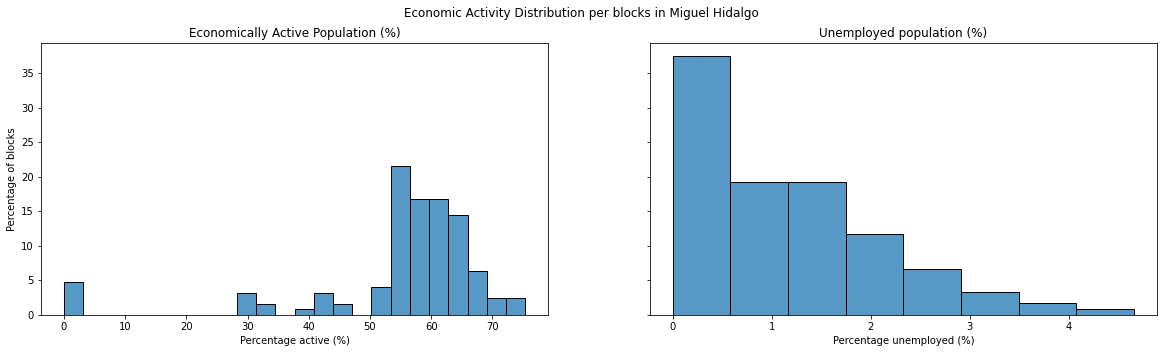

In [32]:
#Plot Miguel Hidalgo 

fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharey=True, sharex = False)
fig.suptitle('Economic Activity Distribution per blocks in Miguel Hidalgo')

# Población economicamente activa
sns.histplot(ax=axes[0], data = grouped_MH, x="porcentaje activo", stat = "percent")
axes[0].set_xlabel("Percentage active (%)")
axes[0].set_ylabel("Percentage of blocks")
axes[0].set_title("Economically Active Population (%)")

# Percentage desempleado
sns.histplot(ax=axes[1], data = grouped_MH, x="porcentaje desempleo", stat = "percent")
axes[1].set_xlabel("Percentage unemployed (%)")
axes[1].set_ylabel("Percentage of blocks")
axes[1].set_title("Unemployed population (%)")

Define AGEBs in Xochimilco

In [33]:
AGEBS_XO = list(set(df1[df1["NOM_MUN"]=="Xochimilco"]["AGEB"]))
grouped_XO = grouped_AGEB.loc[AGEBS_XO,:]
grouped_XO

,POBTOT,POBFEM,POBMAS,PEA,PE_INAC,POCUPADA,PDESOCUP,VIVPAR_HAB,educ. posbasica,no transporte privado,con coche,con moto,con bici,porcentaje activo,porcentaje desempleo
AGEB,,,,,,,,,,,,,,,
0438,7707,3913.0,3779.0,4181.0,2169.0,4110.0,62.0,2000.0,2547.0,1296.0,663.0,105.0,118.0,54.249384,1.482899
0495,4786,2517.0,2268.0,2612.0,1585.0,2545.0,53.0,1273.0,2374.0,662.0,637.0,88.0,215.0,54.575846,2.029096
0211,10025,5289.0,4734.0,5381.0,3354.0,5204.0,138.0,2555.0,5388.0,1137.0,1481.0,284.0,517.0,53.675810,2.564579
0207,8075,4264.0,3811.0,4285.0,2855.0,4110.0,154.0,2299.0,4329.0,1007.0,1315.0,193.0,264.0,53.065015,3.593932
1309,1210,622.0,588.0,630.0,355.0,611.0,17.0,308.0,440.0,170.0,127.0,34.0,59.0,52.066116,2.698413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0067,9228,4862.0,4362.0,5084.0,3136.0,4944.0,121.0,2679.0,5664.0,998.0,1737.0,205.0,459.0,55.093195,2.380016
0029,3439,1859.0,1566.0,1807.0,1324.0,1747.0,34.0,1100.0,2379.0,257.0,808.0,49.0,168.0,52.544344,1.881572
1243,46,23.0,23.0,27.0,13.0,26.0,0.0,19.0,30.0,5.0,13.0,3.0,4.0,58.695652,0.000000


Text(0.5, 1.0, 'Unemployed population (%)')

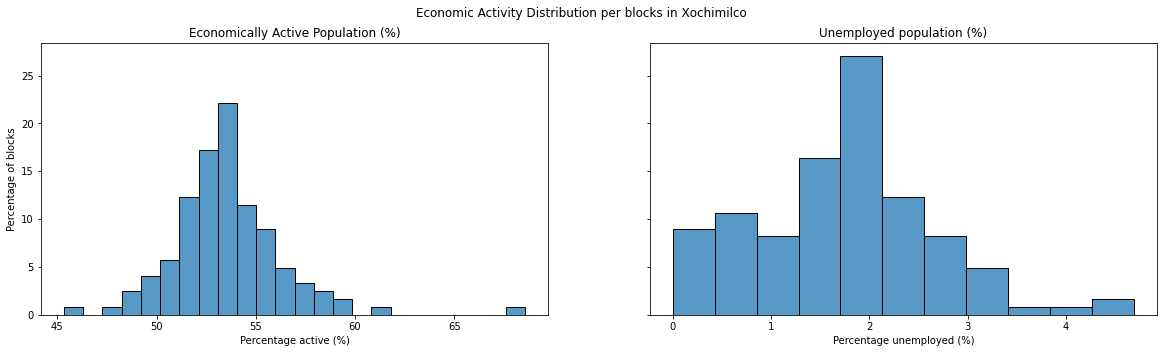

In [34]:
#Plot Xochimilco

fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharey=True, sharex = False)
fig.suptitle('Economic Activity Distribution per blocks in Xochimilco')

# Población economicamente activa
sns.histplot(ax=axes[0], data = grouped_XO, x="porcentaje activo", stat = "percent")
axes[0].set_xlabel("Percentage active (%)")
axes[0].set_ylabel("Percentage of blocks")
axes[0].set_title("Economically Active Population (%)")

# Percentage desempleado
sns.histplot(ax=axes[1], data = grouped_XO, x="porcentaje desempleo", stat = "percent")
axes[1].set_xlabel("Percentage unemployed (%)")
axes[1].set_ylabel("Percentage of blocks")
axes[1].set_title("Unemployed population (%)")

In [35]:
Grouped_ABEG_no_MH_XO = grouped_AGEB.drop(AGEBS_MH+AGEBS_XO, axis = "index")

Define the AGEBS without Miguel Hidalgo and Xochimilco

Text(0.5, 1.0, 'Unemployed population')

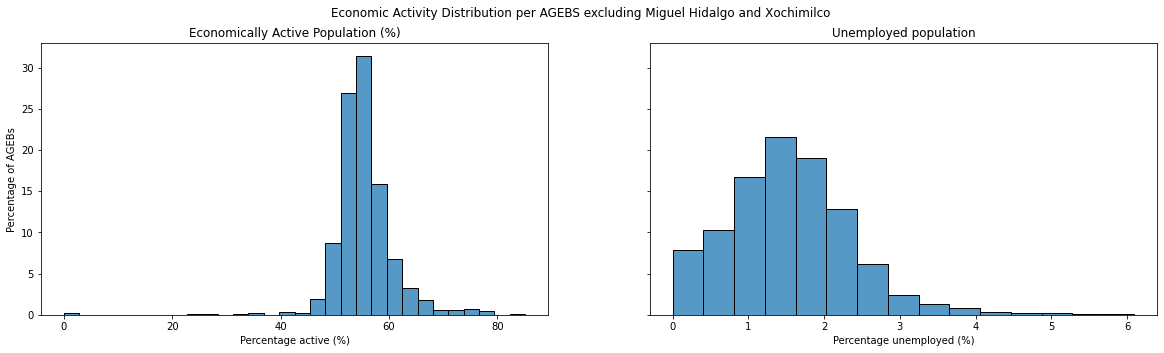

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharey=True, sharex = False)
fig.suptitle('Economic Activity Distribution per AGEBS excluding Miguel Hidalgo and Xochimilco')

# Población economicamente activa
sns.histplot(ax=axes[0], data = Grouped_ABEG_no_MH_XO, x="porcentaje activo", stat = "percent", bins = 30)
axes[0].set_xlabel("Percentage active (%)")
axes[0].set_ylabel("Percentage of AGEBs")
axes[0].set_title("Economically Active Population (%)")


# Percentage desempleado
sns.histplot(ax=axes[1], data = Grouped_ABEG_no_MH_XO, x="porcentaje desempleo", stat = "percent", bins = 15)
axes[1].set_xlabel("Percentage unemployed (%)")
axes[1].set_ylabel("Percentage of AGEBs")
axes[1].set_title("Unemployed population")

PRIVATE TRANSPORTATION

Transporte lo podríamos hacer por porcentaje de FAMILIAS que tiene coche / moto / etc pero me parece más interesante hacerlo por persona raw. Si lo hacemos por familia sería lo mismo decir que el 60% de familias en Ciudad Neza tiene coche igual que las familias en Santa Fe. Pero es muy diferente decir que en una familia cada miembro tiene un coche a que hay 1 coche por familia. Si lo hacemos por persona podemos capturar esto más fácil.

Vamos a ver unas estadísticas a nivel CDMX primero

Dado que nuestros datos de transporte son por VIVIENDA (Número de viviendas que tienen coche, moto, bici), para sacar que porcentaje de la población se mueve en cada uno tenemos que tomar el promedio de personas que se transportan en cada medio. Para esto vamos a tomar los siguientes supuestos:

* Una vivienda con motocicleta y bicicleta transporta a 1 sola persona.
* Para sacar el promedio de personas transportadas por coche sacaremos el weighted average de los datos del reporte [Indice de Movilidad Urbana](https://imco.org.mx/wp-content/uploads/2019/01/I%CC%81ndice-de-Movilidad-Urbana_Documento.pdf):
  * El 68.1% de los viajes en auto transportan a un solo un pasajero
  * Solo el 2.9% de los viajes en auto circulan llenos (con cuatro o más pasajeros)
  * Podemos asumir que los autos que transportan 2 y 3 pasajeros se distribuyen igual (14.5% de los autos transportan 2 y 3 pasajeros)

% car + % motorbike + % bike + % dependent on public transport:  100.0 %


/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


Text(0.5, 0, 'Transport type')

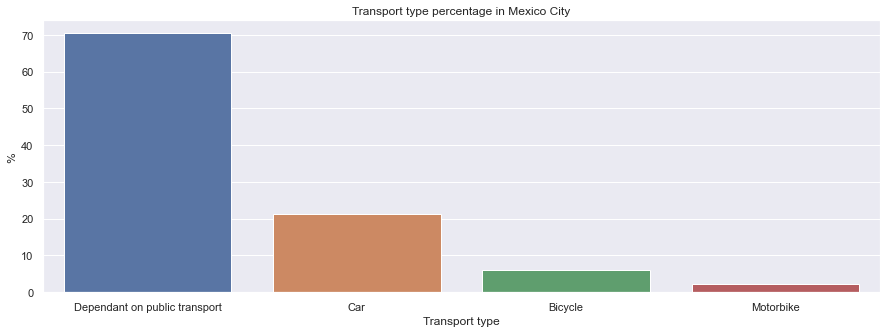

In [37]:
#que porcentaje de todas las casas en la Ciudad de México NO tiene coche? #https://centrourbano.com/urbanismo/mexico-80-la-poblacion-usa-transporte-publico/ 

#En vez de drop 0000 con info agregada de CDMX, hacer un DF con solo con esta información para poderla accesar información agregada de la CDMX y usarla acá

# definiendo número de pasajeros transportados por medio de transporte
pasajeros_coche = (1*0.681)+(2*0.145)+(3*0.145)+(4*0.029)
pasajeros_moto = 1
pasajeros_bici = 1

porcentaje_con_coche = (CDMX_df.loc[0,"con coche"]*pasajeros_coche)/CDMX_df.loc[0,"POBTOT"]*100
porcentaje_con_moto = (CDMX_df.loc[0,"con moto"]*pasajeros_moto)/CDMX_df.loc[0,"POBTOT"]*100
porcentaje_con_bici = (CDMX_df.loc[0,"con bici"]*pasajeros_bici)/CDMX_df.loc[0,"POBTOT"]*100

dependiente_de_transporte_publico = (CDMX_df.loc[0,"POBTOT"] - (CDMX_df.loc[0,"con coche"]*pasajeros_coche) - (CDMX_df.loc[0,"con moto"]*pasajeros_moto)-(CDMX_df.loc[0,"con bici"]*pasajeros_bici))/CDMX_df.loc[0,"POBTOT"]*100

CDMX = pd.DataFrame([[dependiente_de_transporte_publico, porcentaje_con_coche, porcentaje_con_bici, porcentaje_con_moto]], columns=["Dependant on public transport","Car","Bicycle","Motorbike"])

#Sanity check that everything adds up to 100%
print("% car + % motorbike + % bike + % dependent on public transport: ",porcentaje_con_coche + porcentaje_con_moto + porcentaje_con_bici + dependiente_de_transporte_publico,"%")

#Plotting
sns.set(rc={"figure.figsize":(15, 5)})
sns.barplot(data = CDMX)
plt.title("Transport type percentage in Mexico City")
plt.ylabel("%")
plt.xlabel("Transport type")

In [38]:
#Distribution of transport

# Podemos definir a los que dependen de transporte público a los que no tienen moto o coche: no transporte privado + porcentaje bici

grouped_AGEB["porcentaje coche"] = (grouped_AGEB["con coche"]*pasajeros_coche) / grouped_AGEB["POBTOT"]*100
grouped_AGEB["porcentaje moto"] = (grouped_AGEB["con moto"]*pasajeros_moto) / grouped_AGEB["POBTOT"]*100 
grouped_AGEB["porcentaje bici"] = (grouped_AGEB["con bici"]*pasajeros_bici) / grouped_AGEB["POBTOT"]*100 

grouped_AGEB

,POBTOT,POBFEM,POBMAS,PEA,PE_INAC,POCUPADA,PDESOCUP,VIVPAR_HAB,educ. posbasica,no transporte privado,con coche,con moto,con bici,porcentaje activo,porcentaje desempleo,porcentaje coche,porcentaje moto,porcentaje bici
AGEB,,,,,,,,,,,,,,,,,,
0010,3183,1692.0,1483.0,1577.0,1290.0,1527.0,42.0,857.0,1748.0,374.0,478.0,35.0,175.0,49.544455,2.663285,22.856299,1.099592,5.497958
0011,3973,2096.0,1877.0,2675.0,936.0,2637.0,33.0,1524.0,3048.0,586.0,1029.0,150.0,348.0,67.329474,1.233645,39.419532,3.775485,8.759124
0012,6075,3133.0,2930.0,3056.0,2116.0,2993.0,33.0,1796.0,2368.0,1039.0,700.0,97.0,121.0,50.304527,1.079843,17.537449,1.596708,1.991770
0013,5152,2727.0,2425.0,2891.0,1446.0,2824.0,58.0,1480.0,2311.0,939.0,536.0,115.0,303.0,56.114130,2.006226,15.834472,2.232143,5.881211
0014,8271,4420.0,3847.0,4563.0,2720.0,4452.0,79.0,2458.0,4805.0,1072.0,1452.0,216.0,319.0,55.168662,1.731317,26.719188,2.611534,3.856849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5893,5778,3104.0,2674.0,3320.0,1624.0,3253.0,44.0,1587.0,2909.0,893.0,760.0,111.0,163.0,57.459328,1.325301,20.019384,1.921080,2.821045
5906,3780,2018.0,1762.0,2075.0,1165.0,2041.0,18.0,1100.0,1934.0,616.0,478.0,48.0,207.0,54.894180,0.867470,19.246455,1.269841,5.476190
5910,3698,1929.0,1769.0,2198.0,946.0,2156.0,28.0,1157.0,1832.0,736.0,397.0,48.0,173.0,59.437534,1.273885,16.339481,1.297999,4.678204


In [39]:
# Podemos definir a los que dependen de transporte público a los que no tienen moto o coche: no transporte privado + porcentaje bici
#(df1.loc[0,"POBTOT"] - df1.loc[0,"con coche"] - df1.loc[0,"con moto"]-df1.loc[0,"con bici"])/df1.loc[0,"POBTOT"]*100

grouped_AGEB["porcentaje depende de transporte"] = (grouped_AGEB["POBTOT"] - (grouped_AGEB["con coche"]*pasajeros_coche) - (grouped_AGEB["con moto"]*pasajeros_moto) - (grouped_AGEB["con bici"]*pasajeros_bici))/grouped_AGEB["POBTOT"]*100
grouped_AGEB

,POBTOT,POBFEM,POBMAS,PEA,PE_INAC,POCUPADA,PDESOCUP,VIVPAR_HAB,educ. posbasica,no transporte privado,con coche,con moto,con bici,porcentaje activo,porcentaje desempleo,porcentaje coche,porcentaje moto,porcentaje bici,porcentaje depende de transporte
AGEB,,,,,,,,,,,,,,,,,,,
0010,3183,1692.0,1483.0,1577.0,1290.0,1527.0,42.0,857.0,1748.0,374.0,478.0,35.0,175.0,49.544455,2.663285,22.856299,1.099592,5.497958,70.546151
0011,3973,2096.0,1877.0,2675.0,936.0,2637.0,33.0,1524.0,3048.0,586.0,1029.0,150.0,348.0,67.329474,1.233645,39.419532,3.775485,8.759124,48.045860
0012,6075,3133.0,2930.0,3056.0,2116.0,2993.0,33.0,1796.0,2368.0,1039.0,700.0,97.0,121.0,50.304527,1.079843,17.537449,1.596708,1.991770,78.874074
0013,5152,2727.0,2425.0,2891.0,1446.0,2824.0,58.0,1480.0,2311.0,939.0,536.0,115.0,303.0,56.114130,2.006226,15.834472,2.232143,5.881211,76.052174
0014,8271,4420.0,3847.0,4563.0,2720.0,4452.0,79.0,2458.0,4805.0,1072.0,1452.0,216.0,319.0,55.168662,1.731317,26.719188,2.611534,3.856849,66.812429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5893,5778,3104.0,2674.0,3320.0,1624.0,3253.0,44.0,1587.0,2909.0,893.0,760.0,111.0,163.0,57.459328,1.325301,20.019384,1.921080,2.821045,75.238491
5906,3780,2018.0,1762.0,2075.0,1165.0,2041.0,18.0,1100.0,1934.0,616.0,478.0,48.0,207.0,54.894180,0.867470,19.246455,1.269841,5.476190,74.007513
5910,3698,1929.0,1769.0,2198.0,946.0,2156.0,28.0,1157.0,1832.0,736.0,397.0,48.0,173.0,59.437534,1.273885,16.339481,1.297999,4.678204,77.684316


[Text(0.5, 0, '% dependant on public transport'), Text(0, 0.5, '% of AGEBS')]

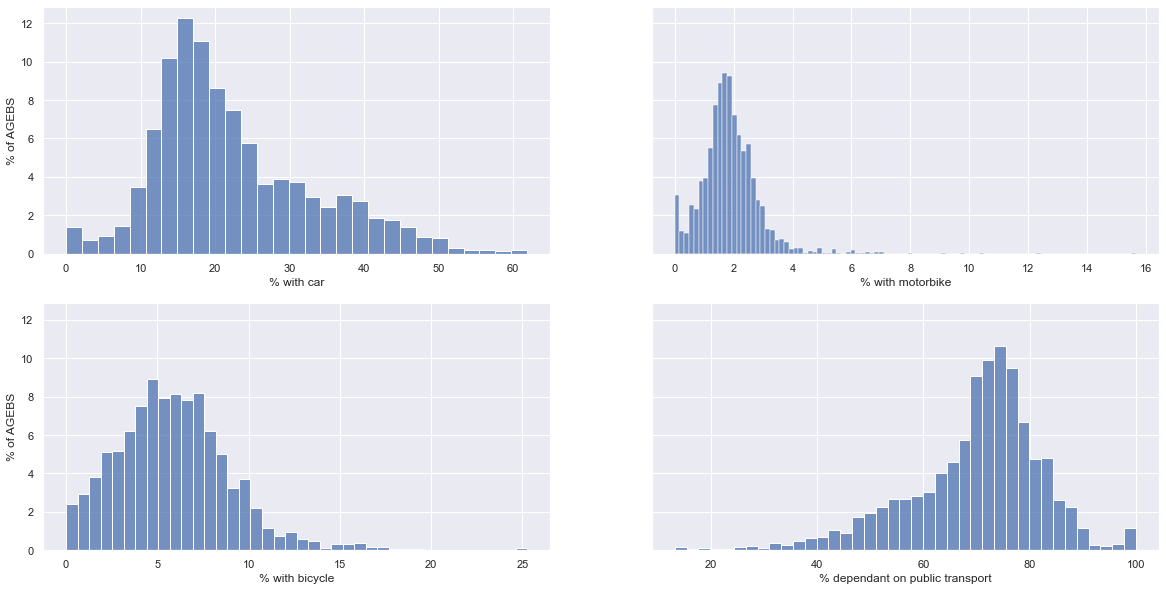

In [40]:
fig, axs = plt.subplots(2,2, figsize=(20, 10), sharey=True, sharex = False)

sns.histplot(ax = axs[0,0], data = grouped_AGEB, x = "porcentaje coche", stat = "percent")
sns.histplot(ax = axs[0,1], data = grouped_AGEB, x = "porcentaje moto", stat = "percent")
sns.histplot(ax = axs[1,0], data = grouped_AGEB, x = "porcentaje bici", stat = "percent")
sns.histplot(ax = axs[1,1], data = grouped_AGEB, x = "porcentaje depende de transporte", stat = "percent")

#setting x labels
axs[0,0].set(xlabel='% with car', ylabel = "% of AGEBS")
axs[0,1].set(xlabel='% with motorbike', ylabel = "% of AGEBS")
axs[1,0].set(xlabel='% with bicycle', ylabel = "% of AGEBS")
axs[1,1].set(xlabel='% dependant on public transport', ylabel = "% of AGEBS")

EDUCACIÓN

In [41]:
#get percentage with educación posbasica
grouped_AGEB["porcentaje educ. posbasica"] = grouped_AGEB["educ. posbasica"] / grouped_AGEB["POBTOT"]*100

#refresh our grouped_XO, grouped_MH and Grouped_ABEG_no_MH_XO variables
grouped_XO = grouped_AGEB.loc[AGEBS_XO,:]
grouped_MH = grouped_AGEB.loc[AGEBS_MH,:]
Grouped_ABEG_no_MH_XO = grouped_AGEB.drop(AGEBS_MH+AGEBS_XO, axis = "index") #lo tenemos que hacer a nivel de manzanas "tenemos que comparar manzanas con manzanas" -Arturin

Text(0.5, 1.0, 'Mexico City (w/o Xochimilco and Miguel Hidalgo)')

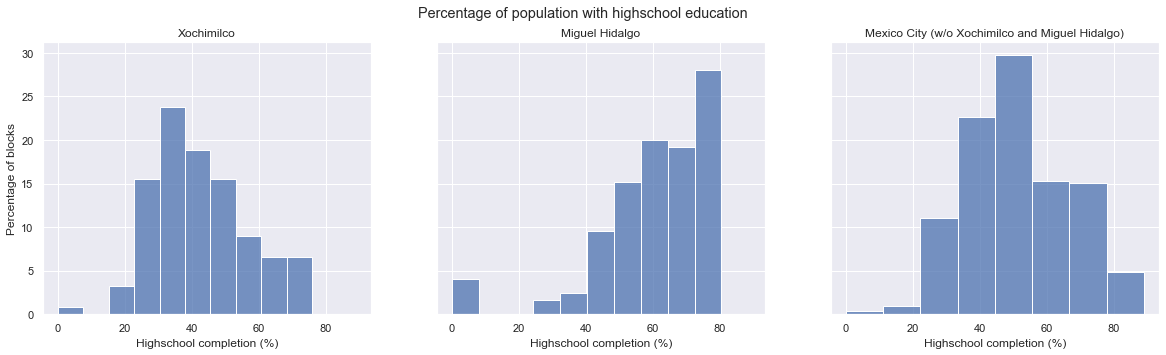

In [42]:
#Plot Xochimilco

fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True, sharex = True)
fig.suptitle('Percentage of population with highschool education')

# Xochimilco
sns.histplot(ax=axes[0], data = grouped_XO, x="porcentaje educ. posbasica", stat = "percent")
axes[0].set_xlabel("Highschool completion (%)")
axes[0].set_ylabel("Percentage of blocks")
axes[0].set_title("Xochimilco")

# Miguel Hidalgo
sns.histplot(ax=axes[1], data = grouped_MH, x="porcentaje educ. posbasica", stat = "percent")
axes[1].set_xlabel("Highschool completion (%)")
axes[1].set_ylabel("Percentage of blocks")
axes[1].set_title("Miguel Hidalgo")

# CDMX
sns.histplot(ax=axes[2], data = Grouped_ABEG_no_MH_XO, x="porcentaje educ. posbasica", stat = "percent", bins = 8) 
axes[2].set_xlabel("Highschool completion (%)")
axes[2].set_ylabel("Percentage of blocks")
axes[2].set_title("Mexico City (w/o Xochimilco and Miguel Hidalgo)")

In [43]:
print(grouped_XO["porcentaje educ. posbasica"].mean())
print(grouped_MH["porcentaje educ. posbasica"].mean())
print(Grouped_ABEG_no_MH_XO["porcentaje educ. posbasica"].mean())

42.65879353960694
60.124566368276064
51.25971047891926


# Cluster descriptives

In [44]:
df_clusters = pd.read_csv("/Users/fernandogutierrez/Desktop/Berkeley/Cyplan 257/Project/Final project submission /GitHub Repo/data/df_agebs.csv")

In [45]:
cluster1_agebs = df_clusters[df_clusters["cluster"]==0]["AGEB"]
cluster2_agebs = df_clusters[df_clusters["cluster"]==1]["AGEB"]
cluster3_agebs = df_clusters[df_clusters["cluster"]==2]["AGEB"]
cluster4_agebs = df_clusters[df_clusters["cluster"]==3]["AGEB"]

In [46]:
grouped_AGEB1 = grouped_AGEB.loc[cluster1_agebs,:]
grouped_AGEB2 = grouped_AGEB.loc[cluster2_agebs,:]
grouped_AGEB3 = grouped_AGEB.loc[cluster3_agebs,:]
grouped_AGEB4 = grouped_AGEB.loc[cluster4_agebs,:]

Economic Activity

Text(0.5, 1.0, 'Cluster 4')

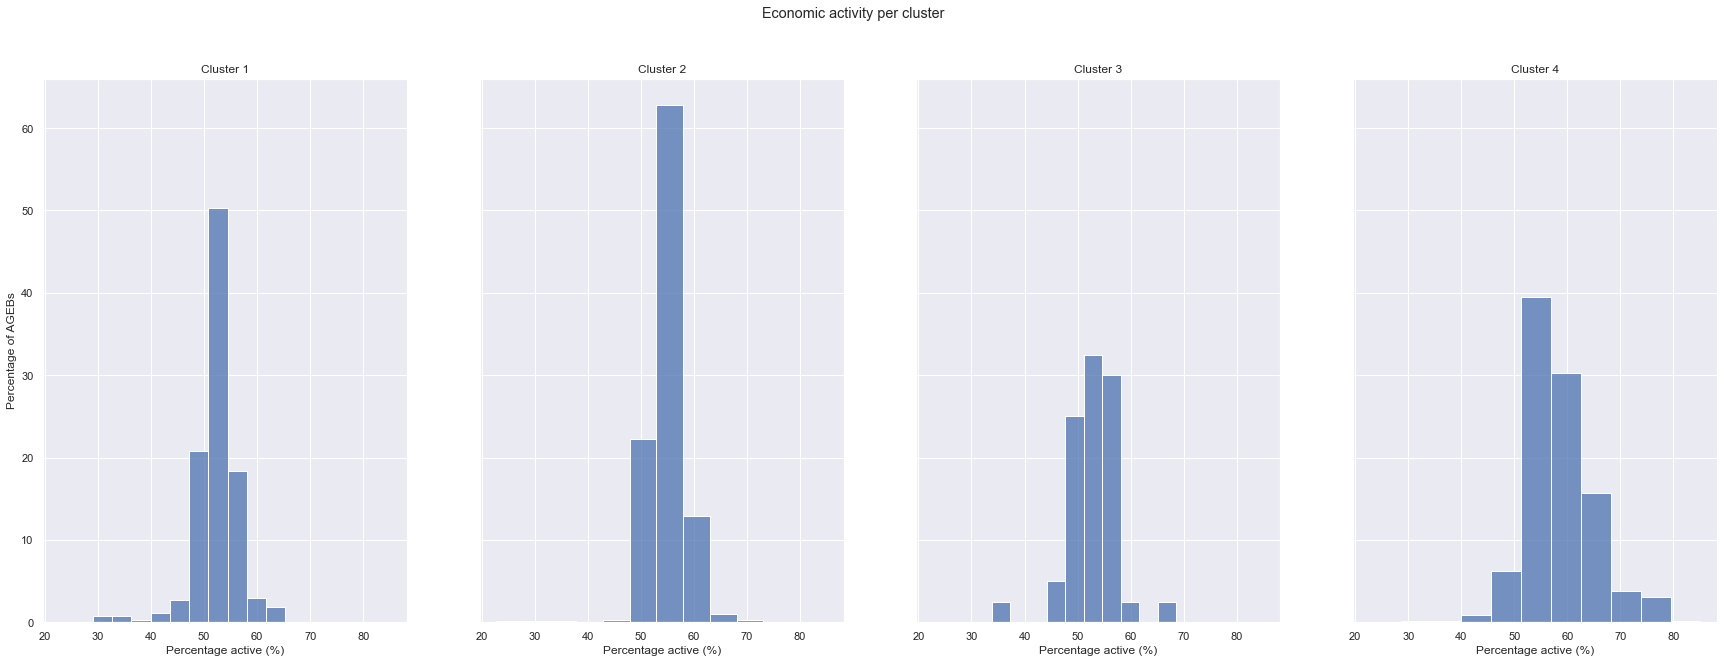

In [47]:
#Plot Economic Activity
fig, axes = plt.subplots(1, 4, figsize=(30, 10), sharey=True, sharex = True)
fig.suptitle('Economic activity per cluster')

# Cluster 1
sns.histplot(ax=axes[0], data = grouped_AGEB1, x="porcentaje activo", stat = "percent", bins = 10)
axes[0].set_xlabel("Percentage active (%)")
axes[0].set_ylabel("Percentage of AGEBs")
axes[0].set_title("Cluster 1")

# Cluster 2
sns.histplot(ax=axes[1], data = grouped_AGEB2, x="porcentaje activo", stat = "percent", bins = 10)
axes[1].set_xlabel("Percentage active (%)")
axes[1].set_ylabel("Percentage of AGEBs")
axes[1].set_title("Cluster 2")

# Cluster 3
sns.histplot(ax=axes[2], data = grouped_AGEB3, x="porcentaje activo", stat = "percent", bins = 10)
axes[2].set_xlabel("Percentage active (%)")
axes[2].set_ylabel("Percentage of AGEBs")
axes[2].set_title("Cluster 3")

# Cluster 4
sns.histplot(ax=axes[3], data = grouped_AGEB4, x="porcentaje activo", stat = "percent", bins = 10)
axes[3].set_xlabel("Percentage active (%)")
axes[3].set_ylabel("Percentage of AGEBs")
axes[3].set_title("Cluster 4")

In [48]:
#printing simple statistics to help us interpret the clusters better

#cluster 1
print("Cluster 1:")
print("Mean", np.mean(grouped_AGEB1["porcentaje activo"]))
print("Median: ", np.median(grouped_AGEB1["porcentaje activo"]))
print("Smallest value",grouped_AGEB1["porcentaje activo"].min())
print("Largest value",grouped_AGEB1["porcentaje activo"].max())
print()
print("----------------------------------------------------------")
print()
print("Cluster 2:")
print("Mean", np.mean(grouped_AGEB2["porcentaje activo"]))
print("Median: ", np.median(grouped_AGEB2["porcentaje activo"]))
print("Smallest value",grouped_AGEB2["porcentaje activo"].min())
print("Largest value",grouped_AGEB2["porcentaje activo"].max())
print()
print("----------------------------------------------------------")
print()
print("Cluster 3:")
print("Mean", np.mean(grouped_AGEB3["porcentaje activo"]))
print("Median: ", np.median(grouped_AGEB3["porcentaje activo"]))
print("Smallest value",grouped_AGEB3["porcentaje activo"].min())
print("Largest value",grouped_AGEB3["porcentaje activo"].max())
print()
print("----------------------------------------------------------")
print()
print("Cluster 4:")
print("Mean", np.mean(grouped_AGEB4["porcentaje activo"]))
print("Median: ", np.median(grouped_AGEB4["porcentaje activo"]))
print("Smallest value",grouped_AGEB4["porcentaje activo"].min())
print("Largest value",grouped_AGEB4["porcentaje activo"].max())

Cluster 1:
Mean 52.28081601906769
Median:  52.338928967813544
Smallest value 28.976377952755904
Largest value 65.3276955602537

----------------------------------------------------------

Cluster 2:
Mean 54.9955185083794
Median:  54.71151058277761
Smallest value 22.727272727272727
Largest value 73.07321772639692

----------------------------------------------------------

Cluster 3:
Mean 52.9862932188997
Median:  53.52693120639189
Smallest value 33.78378378378378
Largest value 68.57142857142857

----------------------------------------------------------

Cluster 4:
Mean 58.420014087813286
Median:  57.27339719970524
Smallest value 28.631801373481245
Largest value 85.1129363449692


Text(0.5, 1.0, 'Cluster 4')

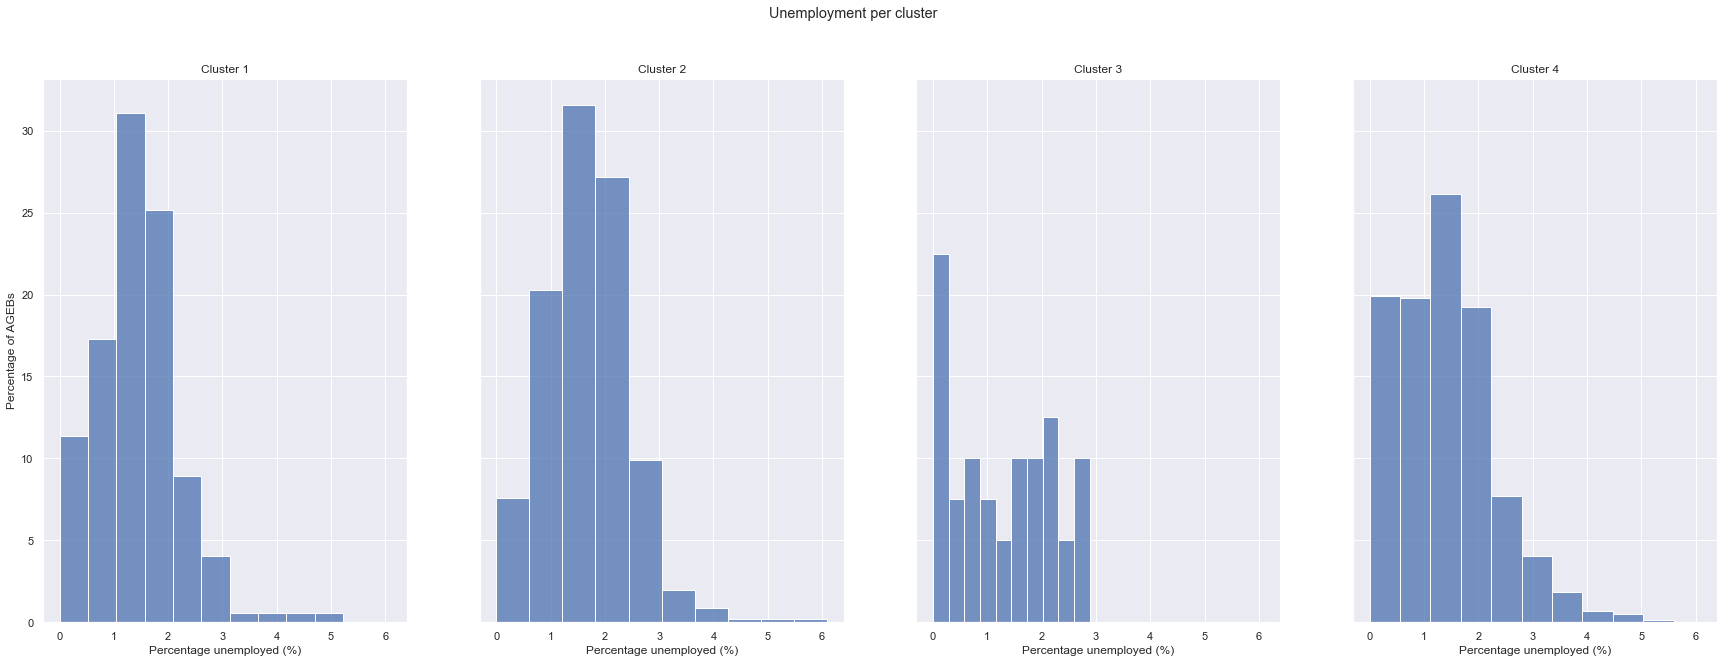

In [49]:
#Plot Unemployment
fig, axes = plt.subplots(1, 4, figsize=(30, 10), sharey=True, sharex = True)
fig.suptitle('Unemployment per cluster')

# Cluster 1
sns.histplot(ax=axes[0], data = grouped_AGEB1, x="porcentaje desempleo", stat = "percent", bins = 10)
axes[0].set_xlabel("Percentage unemployed (%)")
axes[0].set_ylabel("Percentage of AGEBs")
axes[0].set_title("Cluster 1")

# Cluster 2
sns.histplot(ax=axes[1], data = grouped_AGEB2, x="porcentaje desempleo", stat = "percent", bins = 10)
axes[1].set_xlabel("Percentage unemployed (%)")
axes[1].set_ylabel("Percentage of AGEBs")
axes[1].set_title("Cluster 2")

# Cluster 3
sns.histplot(ax=axes[2], data = grouped_AGEB3, x="porcentaje desempleo", stat = "percent", bins = 10)
axes[2].set_xlabel("Percentage unemployed (%)")
axes[2].set_ylabel("Percentage of AGEBs")
axes[2].set_title("Cluster 3")

# Cluster 4
sns.histplot(ax=axes[3], data = grouped_AGEB4, x="porcentaje desempleo", stat = "percent", bins = 10)
axes[3].set_xlabel("Percentage unemployed (%)")
axes[3].set_ylabel("Percentage of AGEBs")
axes[3].set_title("Cluster 4")

In [50]:
#printing simple statistics to help us interpret the clusters better

#cluster 1
print("Cluster 1:")
print("Mean", np.mean(grouped_AGEB1["porcentaje desempleo"]))
print("Median: ", np.median(grouped_AGEB1["porcentaje desempleo"]))
print("Smallest value",grouped_AGEB1["porcentaje desempleo"].min())
print("Largest value",grouped_AGEB1["porcentaje desempleo"].max())
print()
print("----------------------------------------------------------")
print()
print("Cluster 2:")
print("Mean", np.mean(grouped_AGEB2["porcentaje desempleo"]))
print("Median: ", np.median(grouped_AGEB2["porcentaje desempleo"]))
print("Smallest value",grouped_AGEB2["porcentaje desempleo"].min())
print("Largest value",grouped_AGEB2["porcentaje desempleo"].max())
print()
print("----------------------------------------------------------")
print()
print("Cluster 3:")
print("Mean", np.mean(grouped_AGEB3["porcentaje desempleo"]))
print("Median: ", np.median(grouped_AGEB3["porcentaje desempleo"]))
print("Smallest value",grouped_AGEB3["porcentaje desempleo"].min())
print("Largest value",grouped_AGEB3["porcentaje desempleo"].max())
print()
print("----------------------------------------------------------")
print()
print("Cluster 4:")
print("Mean", np.mean(grouped_AGEB4["porcentaje desempleo"]))
print("Median: ", np.median(grouped_AGEB4["porcentaje desempleo"]))
print("Smallest value",grouped_AGEB4["porcentaje desempleo"].min())
print("Largest value",grouped_AGEB4["porcentaje desempleo"].max())

Cluster 1:
Mean 1.4117258875634084
Median:  1.3523498158961171
Smallest value 0.0
Largest value 5.217391304347826

----------------------------------------------------------

Cluster 2:
Mean 1.6697987400016767
Median:  1.643835616438356
Smallest value 0.0
Largest value 6.0908084163898115

----------------------------------------------------------

Cluster 3:
Mean 1.2710758876178982
Median:  1.3787889696882427
Smallest value 0.0
Largest value 2.8841492971400875

----------------------------------------------------------

Cluster 4:
Mean 1.3844124881102522
Median:  1.3485477178423237
Smallest value 0.0
Largest value 5.59610705596107


Text(0.5, 1.0, 'Cluster 4')

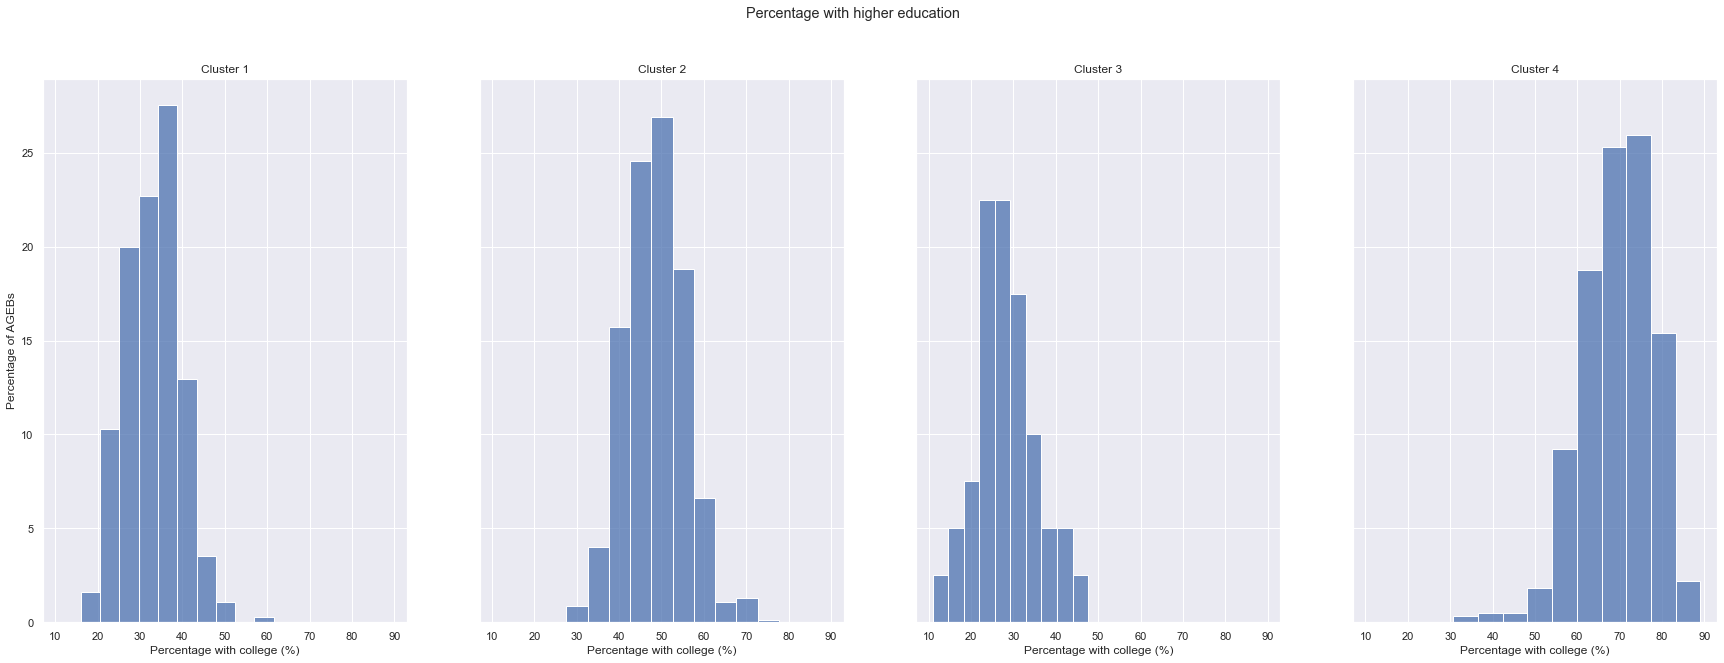

In [51]:
#Plot higher education
fig, axes = plt.subplots(1, 4, figsize=(30, 10), sharey=True, sharex = True)
fig.suptitle('Percentage with higher education')

# Cluster 1
sns.histplot(ax=axes[0], data = grouped_AGEB1, x="porcentaje educ. posbasica", stat = "percent", bins = 10)
axes[0].set_xlabel("Percentage with college (%)")
axes[0].set_ylabel("Percentage of AGEBs")
axes[0].set_title("Cluster 1")

# Cluster 2
sns.histplot(ax=axes[1], data = grouped_AGEB2, x="porcentaje educ. posbasica", stat = "percent", bins = 10)
axes[1].set_xlabel("Percentage with college (%)")
axes[1].set_ylabel("Percentage of AGEBs")
axes[1].set_title("Cluster 2")

# Cluster 3
sns.histplot(ax=axes[2], data = grouped_AGEB3, x="porcentaje educ. posbasica", stat = "percent", bins = 10)
axes[2].set_xlabel("Percentage with college (%)")
axes[2].set_ylabel("Percentage of AGEBs")
axes[2].set_title("Cluster 3")

# Cluster 4
sns.histplot(ax=axes[3], data = grouped_AGEB4, x="porcentaje educ. posbasica", stat = "percent", bins = 10)
axes[3].set_xlabel("Percentage with college (%)")
axes[3].set_ylabel("Percentage of AGEBs")
axes[3].set_title("Cluster 4")

In [52]:
#printing simple statistics to help us interpret the clusters better

#cluster 1
print("Cluster 1:")
print("Mean", np.mean(grouped_AGEB1["porcentaje educ. posbasica"]))
print("Median: ", np.median(grouped_AGEB1["porcentaje educ. posbasica"]))
print("Smallest value",grouped_AGEB1["porcentaje educ. posbasica"].min())
print("Largest value",grouped_AGEB1["porcentaje educ. posbasica"].max())
print()
print("----------------------------------------------------------")
print()
print("Cluster 2:")
print("Mean", np.mean(grouped_AGEB2["porcentaje educ. posbasica"]))
print("Median: ", np.median(grouped_AGEB2["porcentaje educ. posbasica"]))
print("Smallest value",grouped_AGEB2["porcentaje educ. posbasica"].min())
print("Largest value",grouped_AGEB2["porcentaje educ. posbasica"].max())
print()
print("----------------------------------------------------------")
print()
print("Cluster 3:")
print("Mean", np.mean(grouped_AGEB3["porcentaje educ. posbasica"]))
print("Median: ", np.median(grouped_AGEB3["porcentaje educ. posbasica"]))
print("Smallest value",grouped_AGEB3["porcentaje educ. posbasica"].min())
print("Largest value",grouped_AGEB3["porcentaje educ. posbasica"].max())
print()
print("----------------------------------------------------------")
print()
print("Cluster 4:")
print("Mean", np.mean(grouped_AGEB4["porcentaje educ. posbasica"]))
print("Median: ", np.median(grouped_AGEB4["porcentaje educ. posbasica"]))
print("Smallest value",grouped_AGEB4["porcentaje educ. posbasica"].min())
print("Largest value",grouped_AGEB4["porcentaje educ. posbasica"].max())

Cluster 1:
Mean 33.06959605196417
Median:  32.871940214546335
Smallest value 16.0
Largest value 61.53846153846154

----------------------------------------------------------

Cluster 2:
Mean 48.652739828856696
Median:  48.56361149110807
Smallest value 27.547826086956523
Largest value 77.69749518304432

----------------------------------------------------------

Cluster 3:
Mean 28.10833272047976
Median:  26.705735105719835
Smallest value 10.984848484848484
Largest value 47.60233918128655

----------------------------------------------------------

Cluster 4:
Mean 69.36693855882969
Median:  70.35984848484848
Smallest value 30.738480959394067
Largest value 89.09169926119078


Text(0.5, 1.0, 'Cluster 4')

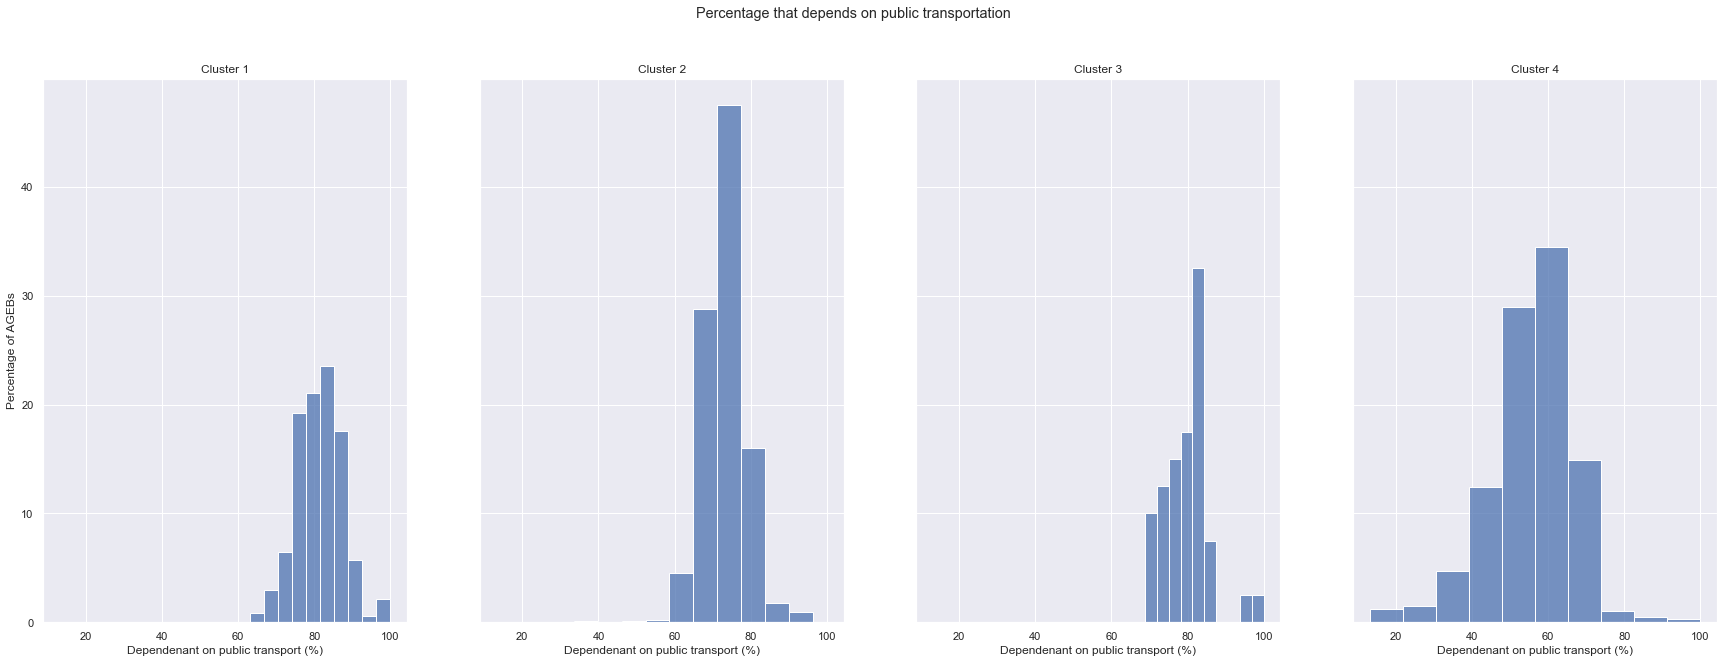

In [53]:
#Plot percentage dependent on transport
fig, axes = plt.subplots(1, 4, figsize=(30, 10), sharey=True, sharex = True)
fig.suptitle('Percentage that depends on public transportation')

# Cluster 1
sns.histplot(ax=axes[0], data = grouped_AGEB1, x="porcentaje depende de transporte", stat = "percent", bins = 10)
axes[0].set_xlabel("Dependenant on public transport (%)")
axes[0].set_ylabel("Percentage of AGEBs")
axes[0].set_title("Cluster 1")

# Cluster 2
sns.histplot(ax=axes[1], data = grouped_AGEB2, x="porcentaje depende de transporte", stat = "percent", bins = 10)
axes[1].set_xlabel("Dependenant on public transport (%)")
axes[1].set_ylabel("Percentage of AGEBs")
axes[1].set_title("Cluster 2")

# Cluster 3
sns.histplot(ax=axes[2], data = grouped_AGEB3, x="porcentaje depende de transporte", stat = "percent", bins = 10)
axes[2].set_xlabel("Dependenant on public transport (%)")
axes[2].set_ylabel("Percentage of AGEBs")
axes[2].set_title("Cluster 3")

# Cluster 4
sns.histplot(ax=axes[3], data = grouped_AGEB4, x="porcentaje depende de transporte", stat = "percent", bins = 10)
axes[3].set_xlabel("Dependenant on public transport (%)")
axes[3].set_ylabel("Percentage of AGEBs")
axes[3].set_title("Cluster 4")

In [54]:
#printing simple statistics to help us interpret the clusters better

#cluster 1
print("Cluster 1:")
print("Mean", np.mean(grouped_AGEB1["porcentaje depende de transporte"]))
print("Median: ", np.median(grouped_AGEB1["porcentaje depende de transporte"]))
print("Smallest value",grouped_AGEB1["porcentaje depende de transporte"].min())
print("Largest value",grouped_AGEB1["porcentaje depende de transporte"].max())
print()
print("----------------------------------------------------------")
print()
print("Cluster 2:")
print("Mean", np.mean(grouped_AGEB2["porcentaje depende de transporte"]))
print("Median: ", np.median(grouped_AGEB2["porcentaje depende de transporte"]))
print("Smallest value",grouped_AGEB2["porcentaje depende de transporte"].min())
print("Largest value",grouped_AGEB2["porcentaje depende de transporte"].max())
print()
print("----------------------------------------------------------")
print()
print("Cluster 3:")
print("Mean", np.mean(grouped_AGEB3["porcentaje depende de transporte"]))
print("Median: ", np.median(grouped_AGEB3["porcentaje depende de transporte"]))
print("Smallest value",grouped_AGEB3["porcentaje depende de transporte"].min())
print("Largest value",grouped_AGEB3["porcentaje depende de transporte"].max())
print()
print("----------------------------------------------------------")
print()
print("Cluster 4:")
print("Mean", np.mean(grouped_AGEB4["porcentaje depende de transporte"]))
print("Median: ", np.median(grouped_AGEB4["porcentaje depende de transporte"]))
print("Smallest value",grouped_AGEB4["porcentaje depende de transporte"].min())
print("Largest value",grouped_AGEB4["porcentaje depende de transporte"].max())

Cluster 1:
Mean 81.39583744996473
Median:  81.5477505207227
Smallest value 63.172505762265395
Largest value 100.0

----------------------------------------------------------

Cluster 2:
Mean 73.36721491904956
Median:  73.23421686746987
Smallest value 33.50394990366088
Largest value 96.33872135102534

----------------------------------------------------------

Cluster 3:
Mean 80.00235859243229
Median:  80.0898365633075
Smallest value 68.801764234162
Largest value 100.0

----------------------------------------------------------

Cluster 4:
Mean 55.738964165301944
Median:  56.89682582021872
Smallest value 13.165292251925681
Largest value 100.0


#_______________________________ ____________________________ ________________ _____________ _______________________________ ____________________________ ________________ _____________ _______________________________ ____________________________ ________________ _____________ _______________________________ ____________________________ ________________ _____________

El transporte público en la Ciudad de México se compone de diferentes medios: 
* metro
* tren ligero
* tren suburbano
* metrobús
* mexibus
* trolebús
* RTP (Rutas de Transporte Público –autobús del gobierno)
* colectivo
* autobús suburbano

# [GTFS estático (General Transit Feed Specification) de la Ciudad de México](https://datos.cdmx.gob.mx/dataset/gtfs)

El GTFS actual comprende ocho archivos en formato texto con sintaxis tipo csv (comma-separated values). Cada archivo contiene al menos un identificador, el cual permite relacionar la información entre los diferentes archivos. La información que describe cada uno de los archivos se encuentra a continuación.

* agency.txt: contiene el nombre de cada una de las agencias, así como páginas de internet donde se puede consultar más información sobre estas.

* routes.txt: incluye el origen y destino de cada una de las líneas, corredores o rutas que integran el Sistema, así como la agencia a la cual pertenecen y el nombre corto de la ruta correspondiente.

* trips.txt: contiene las distintas ramificaciones o variaciones que puede tener una ruta, se indica el sentido de la ruta de transporte y los días de servicio.

* calendar.txt: especifica los días de la semana en que operan los distintos servicios de transporte.

* frequencies.txt: contiene las frecuencias promedio de arribo entre las estaciones de cada viaje que se indican en el archivo trips.txt, así como los horarios de operación.

* shapes.txt: incluye los puntos que conforman el trazado de las rutas de transporte.

* stops.txt: indica la ubicación geográfica de las estaciones, así como el nombre con el que son comúnmente conocidas.

* stop_times.txt: cuenta con la información del tiempo estimado de arribo entre las estaciones o paradas que conforman cada viaje.

In [55]:
import pandas as pd
import zipfile
import numpy as np

In [56]:
#from google.colab import drive
#drive.mount('/content/drive')

In [57]:
with zipfile.ZipFile("/Users/fernandogutierrez/Desktop/Berkeley/Cyplan 257/Project/Final project submission /GitHub Repo/data/gtfs.zip") as item:
    item.extractall()

In [58]:
#visualizing all columns
pd.set_option('display.max_columns', None)

In [59]:
agency = pd.read_csv("agency.txt")
routes = pd.read_csv("routes.txt")
trips = pd.read_csv("trips.txt")
calendar = pd.read_csv("calendar.txt")
frequencies = pd.read_csv("frequencies.txt")
shapes = pd.read_csv("shapes.txt")
stops = pd.read_csv("stops.txt")
stop_times = pd.read_csv("stop_times.txt")

In [60]:
stop_times

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,timepoint
0,010003A000_1,00:00:00,00:00:00,01ITEC10-MPOLI,1,0
1,010003A000_1,00:01:38,00:01:38,01ITEC11-EJEOTHON,2,0
2,010003A000_1,00:03:11,00:03:11,01ITEC11-EJEMTAMAZA,3,0
3,010003A000_1,00:04:31,00:04:31,01ITEC11-EJEJUPITER,4,0
4,010003A000_1,00:07:28,00:07:28,01ITEC11-EJEPROGRESO,5,0
...,...,...,...,...,...,...
40143,03100L4001_0,00:16:30,00:16:30,0300L4-MDOSONORA0,17,0
40144,03100L4001_0,00:18:17,00:18:17,0300L4-CECILIOROB0,18,0
40145,03100L4001_0,00:20:05,00:20:05,0300L4-EDOMOLINA,19,0
40146,03100L4001_0,00:21:25,00:21:25,0300L4-MOCTEZUMA,20,0


In [61]:
print("agency ",agency.shape)
print("routes", routes.shape)
print("trips ",trips.shape)
print("calendar ",calendar.shape)
print("frequencies ", frequencies.shape)
print("shapes ", shapes.shape)
print("stops ", stops.shape)
print("stop times ", stop_times.shape)

agency  (9, 5)
routes (253, 7)
trips  (1179, 7)
calendar  (12, 10)
frequencies  (1622, 5)
shapes  (113328, 5)
stops  (9882, 6)
stop times  (40148, 6)


In [62]:
agency.head()

,agency_id,agency_name,agency_url,agency_timezone,agency_lang
0,PUMABUS,Pumabús,https://www.dgsgm.unam.mx/pumabus,America/Mexico_City,ES
1,CC,Corredores Concesionados,https://datos.cdmx.gob.mx/dataset/?q=corredore...,America/Mexico_City,ES
2,METRO,Sistema de Transporte Colectivo Metro,https://www.metro.cdmx.gob.mx/,America/Mexico_City,ES
3,MB,Metrobús,https://www.metrobus.cdmx.gob.mx,America/Mexico_City,ES
4,TL,Servicio de Tren Ligero,https://www.ste.cdmx.gob.mx/tren-ligero,America/Mexico_City,ES


In [63]:
routes

,route_id,agency_id,route_short_name,route_long_name,route_type,route_color,route_text_color
0,CMX05SE12,RTP,SE12,Constitución de 1917 a Tláhuac,3,76B729,FFFFFF
1,CMX050126,RTP,126,Magdalena Atlitic a Metro Copilco,3,76B729,FFFFFF
2,CMX01024D,CC,24D,Estadio Azteca - Santo Domingo,3,9B26B6,FFFFFF
3,CMX01024C,CC,24C,División del Norte - Sauzales,3,9B26B6,FFFFFF
4,CMX01024B,CC,24B,Merced - Salto del Agua - Cuemanco,3,9B26B6,FFFFFF
...,...,...,...,...,...,...,...
248,CMX05EL12,RTP,SE L12,Tláhuac - Olivos,3,NaN,NaN
249,CMX03SL12,MB,SE L12,Tláhuac - Coyuya (servicio emergente),3,NaN,NaN
250,CMX03EL12,MB,SE L12,Atlalilco - Tláhuac (servicio emergente),3,NaN,NaN
251,CMX020L12,METRO,12,Tláhuac - Mixcoac,1,B99E51,FFFFFF


In [64]:
trips
#trips[trips["trip_id"] == "03300L4001_1"]

,route_id,service_id,trip_id,trip_headsign,trip_short_name,direction_id,shape_id
0,CMX01001C,0,010001C000_1,Canal de Chalco - Barranca del Muerto,C.Base Periférico Canal de Chalco to Base Barr...,1,SH01001C000_1
1,CMX01001C,0,010001C000_0,Barranca del Muerto - Canal de Chalco,C.Base Barranca del Muerto to Base Periférico ...,0,SH01001C000_0
2,CMX01001B,0,010001B000_1,Canal de Chalco - Tacubaya,B.Base Periférico Canal de Chalco to Base Tacu...,1,SH01001B000_1
3,CMX01001B,0,010001B000_0,Tacubaya - Canal de Chalco,B.Base Tacubaya to Base Periférico Canal de Ch...,0,SH01001B000_0
4,CMX01001A,0,010001A000_1,Canal de Chalco - Cuatro Caminos,A.Base Canal de Chalco to Base Cuatro Caminos,1,SH01001A000_1
...,...,...,...,...,...,...,...
1174,CMX0300L4,3,03300L4002_0,San Lázaro (Norte),Buenavista to San Lázaro (Norte),0,SH0300L4002_0
1175,CMX0300L4,2,03200L4002_1,Buenavista (Norte),San Lázaro to Buenavista (Norte),1,SH0300L4002_1
1176,CMX0300L4,2,03200L4002_0,San Lázaro (Norte),Buenavista to San Lázaro (Norte),0,SH0300L4002_0
1177,CMX0300L4,1,03100L4002_1,Buenavista (Norte),San Lázaro to Buenavista (Norte),1,SH0300L4002_1


In [65]:
calendar

,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,9,0,0,0,1,0,0,1,20220101,20221231
1,8,1,1,1,0,1,1,0,20220101,20221231
2,7,0,0,0,1,0,1,1,20220101,20221231
3,6,1,1,1,0,1,0,0,20220101,20221231
4,5,0,0,0,0,0,1,1,20220101,20221231
5,4,1,1,1,1,1,1,0,20220101,20221231
6,0,1,1,1,1,1,1,1,20220101,20221231
7,3,0,0,0,0,0,0,1,20220101,20221231
8,2,0,0,0,0,0,1,0,20220101,20221231
9,1,1,1,1,1,1,0,0,20220101,20221231


In [66]:
frequencies

,trip_id,start_time,end_time,headway_secs,exact_times
0,03300L4001_1,05:02:00,23:32:00,300,0
1,03300L4001_0,05:00:00,24:01:00,300,0
2,03200L4001_1,04:31:00,23:46:00,300,0
3,03200L4001_0,04:36:00,24:03:00,300,0
4,03100L4001_1,04:34:00,23:22:00,300,0
...,...,...,...,...,...
1617,02300L1000_0,07:00:00,24:00:00,240,0
1618,02200L1000_1,06:00:00,24:00:00,240,0
1619,02200L1000_0,06:00:00,24:00:00,240,0
1620,02100L1000_1,05:00:00,24:00:00,240,0


In [67]:
print(len(set(trips["trip_id"])))
print(len(set(shapes["shape_id"])))#.head()
shapes[shapes["shape_id"] == "SH0300L4001_1"]

1179
618


,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled
113221,SH0300L4001_1,19.430898,-99.115434,1,0.00
113222,SH0300L4001_1,19.430239,-99.115529,2,0.07
113223,SH0300L4001_1,19.429944,-99.115593,3,0.10
113224,SH0300L4001_1,19.429726,-99.115643,4,0.12
113225,SH0300L4001_1,19.428302,-99.115844,5,0.28
...,...,...,...,...,...
113323,SH0300L4001_1,19.440612,-99.152589,103,7.25
113324,SH0300L4001_1,19.440960,-99.152528,104,7.29
113325,SH0300L4001_1,19.442086,-99.152414,105,7.42
113326,SH0300L4001_1,19.444399,-99.152262,106,7.68


In [68]:
stops.head()

,stop_id,stop_name,stop_lat,stop_lon,zone_id,wheelchair_boarding
0,0300L4-20NOVIEMBR,20 de Noviembre,19.42932,-99.13402,0300L4-MSCIUDAD,0
1,0300L4-PINOSRZSR,Pino Suárez Sur,19.42610,-99.13421,0300L4-20NOVIEMBR,0
2,0300L4-SANPABLO,San Pablo,19.42558,-99.13070,0300L4-SANPABLO,0
3,0300L4-FRAYSERVND,Fray Servando,19.42364,-99.13097,0300L4-FRAYSERVND,0
4,0300L4-MSONORASUR,Mercado Sonora Sur,19.42311,-99.12670,0300L4-MSONORASUR,1


In [69]:
stop_times.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,timepoint
0,010003A000_1,00:00:00,00:00:00,01ITEC10-MPOLI,1,0
1,010003A000_1,00:01:38,00:01:38,01ITEC11-EJEOTHON,2,0
2,010003A000_1,00:03:11,00:03:11,01ITEC11-EJEMTAMAZA,3,0
3,010003A000_1,00:04:31,00:04:31,01ITEC11-EJEJUPITER,4,0
4,010003A000_1,00:07:28,00:07:28,01ITEC11-EJEPROGRESO,5,0


Join on agency_id:
* agency
* routes

Join on route_id:
* routes
* trip

Join on service_id:
* trip
* calendar

Join on trip_id:
* stop_times
* frequencies

Join on stop_id:
* stop_times
* stops

In [70]:
df = pd.merge(agency, routes, on = "agency_id")
df = df.merge(trips, on = "route_id")
df = df.merge(calendar, on = "service_id")
df

,agency_id,agency_name,agency_url,agency_timezone,agency_lang,route_id,route_short_name,route_long_name,route_type,route_color,route_text_color,service_id,trip_id,trip_headsign,trip_short_name,direction_id,shape_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,PUMABUS,Pumabús,https://www.dgsgm.unam.mx/pumabus,America/Mexico_City,ES,CMX090R13,PUMA13,Metrobús CU - Unidad de Posgrado,3,NaN,NaN,1,0910R13000_0,Base Metrobús CU,Base Metrobús CU - Unidad de Posgrado,0,SH090R13000_0,1,1,1,1,1,0,0,20220101,20221231
1,PUMABUS,Pumabús,https://www.dgsgm.unam.mx/pumabus,America/Mexico_City,ES,CMX090R11,PUMA11,Metrobús CU - AAPAUNAM,3,5155A4,NaN,1,0910R11000_0,Base Metrobús CU,Base Metrobús CU - AAPAUNAM,0,SH090R11000_0,1,1,1,1,1,0,0,20220101,20221231
2,PUMABUS,Pumabús,https://www.dgsgm.unam.mx/pumabus,America/Mexico_City,ES,CMX090R10,PUMA10,Metrobús CU - Av. Imán,3,2D1C0C,NaN,1,0910R10000_0,Metrobús CU,Metrobús CU - Av. Iman,0,SH090R10000_0,1,1,1,1,1,0,0,20220101,20221231
3,PUMABUS,Pumabús,https://www.dgsgm.unam.mx/pumabus,America/Mexico_City,ES,CMX0900R9,PUMA9,Metrobús CU - Islas,3,830A2B,NaN,1,09100R9000_0,Base Metrobús CU,Base Metrobús CU - Islas,0,SH0900R9000_0,1,1,1,1,1,0,0,20220101,20221231
4,PUMABUS,Pumabús,https://www.dgsgm.unam.mx/pumabus,America/Mexico_City,ES,CMX0900R8,PUMA8,Metrobús CU - Estadio Olímpico Universitario (...,3,003E69,NaN,1,09100R8000_0,Base Metrobús CU,Base Metrobús CU - Estadio (por alberca),0,SH0900R8000_0,1,1,1,1,1,0,0,20220101,20221231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1174,TROLE,Trolebús,https://www.ste.cdmx.gob.mx/,America/Mexico_City,ES,CMX0400L7,7,Av. Tláhuac / Ciudad Universitaria,3,1F5AF0,FFFFFF,4,04400L7000_0,Ciudad Universitaria,Tláhuac to Ciudad Universitaria,0,SH0400L7000_0,1,1,1,1,1,1,0,20220101,20221231
1175,RTP,Red de Transporte de Pasajeros,https://www.rtp.cdmx.gob.mx,America/Mexico_City,ES,CMX05034B,34-B,ECOBÚS Santa Fe - Metro Miguel Ángel de Quevedo,3,f39205,NaN,B,05B034B000_1,C. C. Centro Comercial Santa Fe - Av. Vasco de...,34-B 16:05 to C. C. Centro Comercial Santa Fe ...,1,SH05034B000_1,0,1,0,0,0,1,0,20220101,20221231
1176,RTP,Red de Transporte de Pasajeros,https://www.rtp.cdmx.gob.mx,America/Mexico_City,ES,CMX05034B,34-B,ECOBÚS Santa Fe - Metro Miguel Ángel de Quevedo,3,f39205,NaN,B,05B034B000_0,Av. Universidad - Metro Miguel Ángel de Quevedo,34-B 16:05 to Av. Universidad - Metro Miguel Á...,0,SH05034B000_0,0,1,0,0,0,1,0,20220101,20221231
1177,RTP,Red de Transporte de Pasajeros,https://www.rtp.cdmx.gob.mx,America/Mexico_City,ES,CMX05034B,34-B,ECOBÚS Santa Fe - Metro Miguel Ángel de Quevedo,3,f39205,NaN,A,05A034B000_1,C. C. Centro Comercial Santa Fe - Av. Vasco de...,34-B 16:05 to C. C. Centro Comercial Santa Fe ...,1,SH05034B000_1,1,0,1,1,1,0,0,20220101,20221231


In [71]:
df1 = pd.merge(stop_times, frequencies, on = "trip_id")
df1 = df1.merge(stops, on = "stop_id")
df1

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,timepoint,start_time,end_time,headway_secs,exact_times,stop_name,stop_lat,stop_lon,zone_id,wheelchair_boarding
0,010003A000_1,00:00:00,00:00:00,01ITEC10-MPOLI,1,0,6:00:00,10:59:00,480,0,Metro Politécnico,19.50095,-99.14860,01ITEC10-MPOLI,0
1,010003A000_0,00:49:18,00:49:18,01ITEC10-MPOLI,24,0,6:00:00,10:59:00,480,0,Metro Politécnico,19.50095,-99.14860,01ITEC10-MPOLI,0
2,010003A000_1,00:01:38,00:01:38,01ITEC11-EJEOTHON,2,0,6:00:00,10:59:00,480,0,Eje Central y Othon de Mendizabal,19.50472,-99.15029,01ITEC11-EJEOTHON,0
3,01000Z1000_1,00:44:11,00:44:11,01ITEC11-EJEOTHON,29,0,05:00:00,23:00:00,270,0,Eje Central y Othon de Mendizabal,19.50472,-99.15029,01ITEC11-EJEOTHON,0
4,01000Z1001_1,00:34:48,00:34:48,01ITEC11-EJEOTHON,30,0,05:00:00,23:00:00,270,0,Eje Central y Othon de Mendizabal,19.50472,-99.15029,01ITEC11-EJEOTHON,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58132,03200L4001_0,00:10:11,00:10:11,0300L4-SALVADOR1,11,0,04:36:00,24:03:00,300,0,El Salvador,19.42987,-99.13854,0300L4-SALVADOR1,0
58133,03100L4001_0,00:10:11,00:10:11,0300L4-SALVADOR1,11,0,04:39:00,24:01:00,300,0,El Salvador,19.42987,-99.13854,0300L4-SALVADOR1,0
58134,03300L4001_0,00:10:40,00:10:40,0300L4-ISABELCATOLI0,12,0,05:00:00,24:01:00,300,0,Isabel la Católica,19.42962,-99.13701,0300L4-ISABELCATOLI0,0
58135,03200L4001_0,00:10:40,00:10:40,0300L4-ISABELCATOLI0,12,0,04:36:00,24:03:00,300,0,Isabel la Católica,19.42962,-99.13701,0300L4-ISABELCATOLI0,0


In [72]:
df = df.merge(df1, on = "trip_id")
df

,agency_id,agency_name,agency_url,agency_timezone,agency_lang,route_id,route_short_name,route_long_name,route_type,route_color,route_text_color,service_id,trip_id,trip_headsign,trip_short_name,direction_id,shape_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date,arrival_time,departure_time,stop_id,stop_sequence,timepoint,start_time,end_time,headway_secs,exact_times,stop_name,stop_lat,stop_lon,zone_id,wheelchair_boarding
0,PUMABUS,Pumabús,https://www.dgsgm.unam.mx/pumabus,America/Mexico_City,ES,CMX090R13,PUMA13,Metrobús CU - Unidad de Posgrado,3,NaN,NaN,1,0910R13000_0,Base Metrobús CU,Base Metrobús CU - Unidad de Posgrado,0,SH090R13000_0,1,1,1,1,1,0,0,20220101,20221231,00:11:12,00:11:12,0900R1-FILOSOFIA,8,0,06:00:00,22:00:00,480,0,Facultad de Filosofía,19.33467,-99.18778,0900R1-FILOSOFIA,0
1,PUMABUS,Pumabús,https://www.dgsgm.unam.mx/pumabus,America/Mexico_City,ES,CMX090R13,PUMA13,Metrobús CU - Unidad de Posgrado,3,NaN,NaN,1,0910R13000_0,Base Metrobús CU,Base Metrobús CU - Unidad de Posgrado,0,SH090R13000_0,1,1,1,1,1,0,0,20220101,20221231,00:12:48,00:12:48,0900R1-FDERECHO,9,0,06:00:00,22:00:00,480,0,Facultad de Derecho,19.33500,-99.18478,0900R1-FDERECHO,0
2,PUMABUS,Pumabús,https://www.dgsgm.unam.mx/pumabus,America/Mexico_City,ES,CMX090R13,PUMA13,Metrobús CU - Unidad de Posgrado,3,NaN,NaN,1,0910R13000_0,Base Metrobús CU,Base Metrobús CU - Unidad de Posgrado,0,SH090R13000_0,1,1,1,1,1,0,0,20220101,20221231,00:06:24,00:06:24,0900R3-FCPOLITICAS,5,0,06:00:00,22:00:00,480,0,Facultad de Ciencias Políticas,19.31780,-99.17641,0900R3-FCPOLITICAS,0
3,PUMABUS,Pumabús,https://www.dgsgm.unam.mx/pumabus,America/Mexico_City,ES,CMX090R13,PUMA13,Metrobús CU - Unidad de Posgrado,3,NaN,NaN,1,0910R13000_0,Base Metrobús CU,Base Metrobús CU - Unidad de Posgrado,0,SH090R13000_0,1,1,1,1,1,0,0,20220101,20221231,00:08:00,00:08:00,0900R3-IJURIDICAS2,6,0,06:00:00,22:00:00,480,0,Investigaciones Jurídicas 2,19.31723,-99.18069,0900R3-IJURIDICAS2,0
4,PUMABUS,Pumabús,https://www.dgsgm.unam.mx/pumabus,America/Mexico_City,ES,CMX090R13,PUMA13,Metrobús CU - Unidad de Posgrado,3,NaN,NaN,1,0910R13000_0,Base Metrobús CU,Base Metrobús CU - Unidad de Posgrado,0,SH090R13000_0,1,1,1,1,1,0,0,20220101,20221231,00:01:36,00:01:36,0900R3-BIBLIOTECNAL2,2,0,06:00:00,22:00:00,480,0,Biblioteca Nacional 2,19.31544,-99.18637,0900R3-BIBLIOTECNAL2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58132,RTP,Red de Transporte de Pasajeros,https://www.rtp.cdmx.gob.mx,America/Mexico_City,ES,CMX05034B,34-B,ECOBÚS Santa Fe - Metro Miguel Ángel de Quevedo,3,f39205,NaN,A,05A034B000_0,Av. Universidad - Metro Miguel Ángel de Quevedo,34-B 16:05 to Av. Universidad - Metro Miguel Á...,0,SH05034B000_0,1,0,1,1,1,0,0,20220101,20221231,01:23:16,01:23:16,05034B0-JRNMFUENTES,22,0,05:00:00,24:00:00,480,0,Av. San Jerónimo - Las Fuentes,19.33272,-99.20473,05034B0-JRNMFUENTES,0
58133,RTP,Red de Transporte de Pasajeros,https://www.rtp.cdmx.gob.mx,America/Mexico_City,ES,CMX05034B,34-B,ECOBÚS Santa Fe - Metro Miguel Ángel de Quevedo,3,f39205,NaN,A,05A034B000_0,Av. Universidad - Metro Miguel Ángel de Quevedo,34-B 16:05 to Av. Universidad - Metro Miguel Á...,0,SH05034B000_0,1,0,1,1,1,0,0,20220101,20221231,01:30:02,01:30:02,05034B0-EJ10SREVOLUCI,25,0,05:00:00,24:00:00,480,0,Eje 10 Sur - Av. Revolución,19.33661,-99.19286,05034B0-EJ10SREVOLUCI,0
58134,RTP,Red de Transporte de Pasajeros,https://www.rtp.cdmx.gob.mx,America/Mexico_City,ES,CMX05034B,34-B,ECOBÚS Santa Fe - Metro Miguel Ángel de Quevedo,3,f39205,NaN,A,05A034B000_0,Av. Universidad - Metro Miguel Ángel de Quevedo,34-B 16:05 to Av. Universidad - Metro Miguel Á...,0,SH05034B000_0,1,0,1,1,1,0,0,20220101,20221231,01:33:16,01:33:16,05034B0-UNIVERSIDUNAM,26,0,05:00:00,24:00:00,480,0,Av. Universidad - UNAM,19.33684,-99.18677,05034B0-UNIVERSIDUNAM,0
58135,RTP,Red de Transporte de Pasajeros,https://www.rtp.cdmx.gob.mx,Americ

In [73]:
#df.to_csv("/content/drive/MyDrive/CYPLAN 257 personal/Project/df_para_victor.csv", index=False)

Loading DF with AGEBs column made on Qgis

In [74]:
df = pd.read_csv("/Users/fernandogutierrez/Desktop/Berkeley/Cyplan 257/Project/Final project submission /GitHub Repo/data/GTFS estático (General Transit Feed Specification) de la Ciudad de México MERGED AND WITH AGEBS.csv")


/var/folders/cr/mwjn7_vx4290gyhrvfv_04nm0000gn/T/ipykernel_34067/3504386176.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/Users/fernandogutierrez/Desktop/Berkeley/Cyplan 257/Project/Final project submission /GitHub Repo/data/GTFS estático (General Transit Feed Specification) de la Ciudad de México MERGED AND WITH AGEBS.csv")


In [75]:
df.shape

(58137, 41)

In [76]:
df.rename({"CVE_AGEB":"AGEB"}, axis = "columns", inplace = True)
df.drop(["agency_timezone",
         "agency_url",
         "agency_lang",
         "route_color",
         "route_text_color",
         "wheelchair_boarding"],
        axis = 1,
        inplace = True) #dropping unnecessary columns 
df

,agency_id,agency_name,route_id,route_short_name,route_long_name,route_type,service_id,trip_id,trip_headsign,trip_short_name,direction_id,shape_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date,arrival_time,departure_time,stop_id,stop_sequence,timepoint,start_time,end_time,headway_secs,exact_times,stop_name,stop_lat,stop_lon,zone_id,AGEB
0,RTP,Red de Transporte de Pasajeros,CMX05057A,57-A,Metro Cuatro Caminos - Metro Constitución de 1917,3,1,05157AX000_0,C. C. Constitución de 1917 - Calz. Ermita Izta...,57-A 16:49 to C. C. Constitución de 1917 - Cal...,False,SH05057A000_0,True,True,True,True,True,False,False,20220101,20221231,00:28:04,00:28:04,05057A0-APSANTONIO,4,False,19:00:00,24:00:00,1080,False,Anillo Periférico Sur - San Antonio,19.38424,-99.19139,05057A0-APSANTONIO,2150
1,RTP,Red de Transporte de Pasajeros,CMX05057A,57-A,Metro Cuatro Caminos - Metro Constitución de 1917,3,1,05157AX000_0,C. C. Constitución de 1917 - Calz. Ermita Izta...,57-A 16:49 to C. C. Constitución de 1917 - Cal...,False,SH05057A000_0,True,True,True,True,True,False,False,20220101,20221231,00:28:04,00:28:04,05057A0-APSANTONIO,4,False,05:00:00,19:00:00,780,False,Anillo Periférico Sur - San Antonio,19.38424,-99.19139,05057A0-APSANTONIO,2150
2,RTP,Red de Transporte de Pasajeros,CMX05057C,57-C,Metro Constitución de 1917 - Metro Cuatro Cami...,3,1,051057C000_0,C. C. Metro Constitución de 1917 - Cetram Cons...,57-C 18:44 to C. C. Metro Constitución de 1917...,False,SH05057C000_0,True,True,True,True,True,False,False,20220101,20221231,00:53:47,00:53:47,05057A0-APSANTONIO,20,False,06:30:00,21:10:00,4920,False,Anillo Periférico Sur - San Antonio,19.38424,-99.19139,05057A0-APSANTONIO,2150
3,RTP,Red de Transporte de Pasajeros,CMX05057C,57-C,Metro Constitución de 1917 - Metro Cuatro Cami...,3,1,051057C000_0,C. C. Metro Constitución de 1917 - Cetram Cons...,57-C 18:44 to C. C. Metro Constitución de 1917...,False,SH05057C000_0,True,True,True,True,True,False,False,20220101,20221231,00:58:10,00:58:10,05057A0-APSGIRARDON,21,False,06:30:00,21:10:00,4920,False,Anillo Periférico Sur - Fernando Girardon,19.37641,-99.19203,05057A0-APSGIRARDON,2150
4,RTP,Red de Transporte de Pasajeros,CMX050112,112,Ampliación Jalalpa - Metro Tacubaya,3,1,0510112000_0,Metro Tacubaya,Amp. Jalapa to Metro Tacubaya,False,SH050112000_0,True,True,True,True,True,False,False,20220101,20221231,00:38:23,00:38:23,0501120-PERIFERIPTE,34,False,18:30:00,21:40:00,2580,False,"Periférico, Puente hacia Periférico Norte",19.38474,-99.19127,0501120-PERIFERIPTE,2150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58132,RTP,Red de Transporte de Pasajeros,CMX05047A,47-A,Alameda Oriente - Xochimilco / Bosque de Nativ...,3,3,053047A000_1,C. C. Alameda Oriente - Av. Bordo de Xochiaca/...,47-A 17:54 to C. C. Alameda Oriente - Av. Bord...,True,SH05047A000_1,False,False,False,False,False,False,True,20220101,20221231,01:58:35,01:58:35,05047A1-GARAYBRAVO,47,False,05:00:00,24:00:00,960,False,Anillo Periférico Canal de Garay - Valle de Bravo,19.41923,-99.05604,05047A1-GARAYBRAVO,NaN
58133,RTP,Red de Transporte de Pasajeros,CMX05047A,47-A,Alameda Oriente - Xochimilco / Bosque de Nativ...,3,3,053047A000_1,C. C. Alameda Oriente - Av. Bordo de Xochiaca/...,47-A 17:54 to C. C. Alameda Oriente - Av. Bord...,True,SH05047A000_1,False,False,False,False,False,False,True,20220101,20221231,02:00:00,02:00:00,05047A1-GARAYCHIMALH,48,False,05:00:00,24:00:00,960,False,Anillo Periférico Canal de Garay - Av. Chimalh...,19.42184,-99.05572,05047A1-GARAYCHIMALH,NaN
58134,RTP,Red de Transporte de Pasajeros,CMX05047A,47-A,Alameda Oriente - Xochimilco / Bosque de Nativ...,3,3,053047A000_1,C. C. Alameda Oriente - Av. Bordo de Xochiaca/...,47-A 17:54 to C. C. Alameda Oriente - Av. Bord...,True,SH05047A000_1,False,False,False,False,False,False,True,20220101,20221231,02:01:51,02:01:51,05047A1-GARAY6AV,49,False,05:00:00,24:00:00,

In [77]:
#making Monday - Sunday ints
df[["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]] = df[["monday",
                                                                                      "tuesday",
                                                                                      "wednesday",
                                                                                      "thursday",
                                                                                      "friday",
                                                                                      "saturday",
                                                                                      "sunday"]].replace({True: 1, False: 0})
df

,agency_id,agency_name,route_id,route_short_name,route_long_name,route_type,service_id,trip_id,trip_headsign,trip_short_name,direction_id,shape_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date,arrival_time,departure_time,stop_id,stop_sequence,timepoint,start_time,end_time,headway_secs,exact_times,stop_name,stop_lat,stop_lon,zone_id,AGEB
0,RTP,Red de Transporte de Pasajeros,CMX05057A,57-A,Metro Cuatro Caminos - Metro Constitución de 1917,3,1,05157AX000_0,C. C. Constitución de 1917 - Calz. Ermita Izta...,57-A 16:49 to C. C. Constitución de 1917 - Cal...,False,SH05057A000_0,1,1,1,1,1,0,0,20220101,20221231,00:28:04,00:28:04,05057A0-APSANTONIO,4,False,19:00:00,24:00:00,1080,False,Anillo Periférico Sur - San Antonio,19.38424,-99.19139,05057A0-APSANTONIO,2150
1,RTP,Red de Transporte de Pasajeros,CMX05057A,57-A,Metro Cuatro Caminos - Metro Constitución de 1917,3,1,05157AX000_0,C. C. Constitución de 1917 - Calz. Ermita Izta...,57-A 16:49 to C. C. Constitución de 1917 - Cal...,False,SH05057A000_0,1,1,1,1,1,0,0,20220101,20221231,00:28:04,00:28:04,05057A0-APSANTONIO,4,False,05:00:00,19:00:00,780,False,Anillo Periférico Sur - San Antonio,19.38424,-99.19139,05057A0-APSANTONIO,2150
2,RTP,Red de Transporte de Pasajeros,CMX05057C,57-C,Metro Constitución de 1917 - Metro Cuatro Cami...,3,1,051057C000_0,C. C. Metro Constitución de 1917 - Cetram Cons...,57-C 18:44 to C. C. Metro Constitución de 1917...,False,SH05057C000_0,1,1,1,1,1,0,0,20220101,20221231,00:53:47,00:53:47,05057A0-APSANTONIO,20,False,06:30:00,21:10:00,4920,False,Anillo Periférico Sur - San Antonio,19.38424,-99.19139,05057A0-APSANTONIO,2150
3,RTP,Red de Transporte de Pasajeros,CMX05057C,57-C,Metro Constitución de 1917 - Metro Cuatro Cami...,3,1,051057C000_0,C. C. Metro Constitución de 1917 - Cetram Cons...,57-C 18:44 to C. C. Metro Constitución de 1917...,False,SH05057C000_0,1,1,1,1,1,0,0,20220101,20221231,00:58:10,00:58:10,05057A0-APSGIRARDON,21,False,06:30:00,21:10:00,4920,False,Anillo Periférico Sur - Fernando Girardon,19.37641,-99.19203,05057A0-APSGIRARDON,2150
4,RTP,Red de Transporte de Pasajeros,CMX050112,112,Ampliación Jalalpa - Metro Tacubaya,3,1,0510112000_0,Metro Tacubaya,Amp. Jalapa to Metro Tacubaya,False,SH050112000_0,1,1,1,1,1,0,0,20220101,20221231,00:38:23,00:38:23,0501120-PERIFERIPTE,34,False,18:30:00,21:40:00,2580,False,"Periférico, Puente hacia Periférico Norte",19.38474,-99.19127,0501120-PERIFERIPTE,2150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58132,RTP,Red de Transporte de Pasajeros,CMX05047A,47-A,Alameda Oriente - Xochimilco / Bosque de Nativ...,3,3,053047A000_1,C. C. Alameda Oriente - Av. Bordo de Xochiaca/...,47-A 17:54 to C. C. Alameda Oriente - Av. Bord...,True,SH05047A000_1,0,0,0,0,0,0,1,20220101,20221231,01:58:35,01:58:35,05047A1-GARAYBRAVO,47,False,05:00:00,24:00:00,960,False,Anillo Periférico Canal de Garay - Valle de Bravo,19.41923,-99.05604,05047A1-GARAYBRAVO,NaN
58133,RTP,Red de Transporte de Pasajeros,CMX05047A,47-A,Alameda Oriente - Xochimilco / Bosque de Nativ...,3,3,053047A000_1,C. C. Alameda Oriente - Av. Bordo de Xochiaca/...,47-A 17:54 to C. C. Alameda Oriente - Av. Bord...,True,SH05047A000_1,0,0,0,0,0,0,1,20220101,20221231,02:00:00,02:00:00,05047A1-GARAYCHIMALH,48,False,05:00:00,24:00:00,960,False,Anillo Periférico Canal de Garay - Av. Chimalh...,19.42184,-99.05572,05047A1-GARAYCHIMALH,NaN
58134,RTP,Red de Transporte de Pasajeros,CMX05047A,47-A,Alameda Oriente - Xochimilco / Bosque de Nativ...,3,3,053047A000_1,C. C. Alameda Oriente - Av. Bordo de Xochiaca/...,47-A 17:54 to C. C. Alameda Oriente - Av. Bord...,True,SH05047A000_1,0,0,0,0,0,0,1,20220101,20221231,02:01:51,02:01:51,05047A1-GARAY6AV,49,False,05:00:00,24:00:00,960,False,Anillo Periférico Canal de Garay - Sexta Avenida,19.42501,-99.05451,05047A1-GARAY6AV,NaN
58135,RTP,Red de Transporte de Pasajeros,CMX05047A,47-A,Alameda Oriente - Xochimilco / Bosque de 

In [78]:
#there are 879 NaNs in this dataframe because they are the locations that are in Estado de México. We will correct this later
df[df["AGEB"].isna()].shape[0]

879

# Supply

## Finding capacity per medio de transporte

In [79]:
medios = list(set(df["agency_name"]))
medios

['Pumabús',
 'Metrobús',
 'Cablebus',
 'Trolebús',
 'Corredores Concesionados',
 'Sistema de Transporte Colectivo Metro',
 'Red de Transporte de Pasajeros',
 'Ferrocarriles Suburbanos',
 'Servicio de Tren Ligero']

In [80]:
#calculating average capacity of metrobus
def weighted_average(capacity, number_of_buses):
  """
  Source: https://www.metrobus.cdmx.gob.mx/dependencia/acerca-de/flota#:~:text=Capacidad%20para%20160%20personas,autob%C3%BAs%20articulado%20sustituye%20107%20autom%C3%B3viles
  capacity: passenger capacity per type of metrobus
  number_of_buses: the number of buses per type of bus that are on the fleet
  returns: the weighted avergage of the capacity of metrobuses in Mexico City.
  """
  return sum(np.array(number_of_buses) * np.array(capacity)) / np.array(number_of_buses).sum()

Defining capacity 

In [81]:
print(list(set(df["agency_id"])))
print(list(set(df["agency_name"])))

['METRO', 'PUMABUS', 'TL', 'CBB', 'RTP', 'SUB', 'TROLE', 'MB', 'CC']
['Pumabús', 'Metrobús', 'Cablebus', 'Trolebús', 'Corredores Concesionados', 'Sistema de Transporte Colectivo Metro', 'Red de Transporte de Pasajeros', 'Ferrocarriles Suburbanos', 'Servicio de Tren Ligero']


* MB = metrobus
* CC = corredores concesionados
* SUB = ferrocarriles suburbanos
* RTP = Red de Transporte de Pasajeros
* TL = tren ligero
* TROLE = trolebus
* CBB = cablebus
* METRO = Sistema de Transporte Colectivo Metro
* PUMABUS = pumabus


In [82]:
medios_de_transporte = {"MB" : weighted_average([160,124,61,90], [303,240,100,130]),
                        "CC" : 100, #PENDING TO FIND OUT. THIS IS AN ARBITRARY NUMBER
                        "SUB" : 1130, #4 vagones (capacidad 1,130 pasajeros) #https://www.fonadin.gob.mx/fni2/fp01/#:~:text=20%20trenes%20el%C3%A9ctricos%20de%204,atender%20a%20350%20mil%20pasajeros.
                        "RTP" : 100, #Cada camión del RTP tiene capacidad para transportar a 100 personas.
                        "TL" : 300, #capacidad máxima: 300 pasajeros #https://es.wikipedia.org/wiki/Tren_ligero_de_la_Ciudad_de_M%C3%A9xico
                        "TROLE" : weighted_average([85, 142], [80,50]),#https://www.tyt.com.mx/nota/cdmx-anuncia-adquisicion-de-130-trolebuses-50-son-articulados
                        "CBB" : 10, #(10 personas por cabina. 308 cabinas en linea 2) https://politica.expansion.mx/cdmx/2021/08/07/todo-lo-que-debes-saber-de-la-linea-2-del-cablebus-en-iztapalapa
                        "METRO" : 1530, #En los nueve vagones que posee cada tren del metro de la CDMX caben 1,530 personas, 360 sentados y 1,170 parados #https://www.eleconomista.com.mx/politica/Cuanta-gente-viaja-en-metro-en-la-Ciudad-de-Mexico-20200317-0069.html
                        "PUMABUS" : 85 #https://www.tyt.com.mx/nota/el-pumabus-se-renueva-con-autobuses-volkswagen
                        }

## Finding frequency 

We are defining frequency as the number of times that a services passes per day (ej. en la parada Anillo Periférico Sur - San Antonio pasa el RTP 15 veces por día, o algo así)

1. Make function that takes in df and weekday
2. Select only important columns for getting frequency per transport per AGEB
  3. Function selects day first ✅
  4. Makes groupby object by selecting AGEB ✅
  5. After grouping by AGEB it indexes by transport system ✅
  6. It returns a Series/DataFrame with the COUNT of times that each medio de transporte passes per day per AGEB ✅

In [83]:
#Defining function to return frequency per medio de transporte per AGEB per day
def frequency(df, day):
  dataframe = df[["agency_id",
                  "monday", 
                  "tuesday", 
                  "wednesday", 
                  "thursday", 
                  "friday",
                  "saturday",
                  "sunday",
                  "AGEB"]]
  
  active_day = dataframe[dataframe[day]==1]
  grouped = active_day.groupby(["AGEB","agency_id"]).count()

  return grouped
  
frequency(df, "sunday")

monday  tuesday  wednesday  thursday  friday  saturday  sunday
AGEB agency_id                                                                
0012 CC              8        8          8         8       8         8       8
     RTP            36       36         36        36      36        36      36
0013 CC              3        3          3         3       3         3       3
     RTP             1        1          1         1       1         1       1
0014 CC             21       21         21        21      21        21      21
...                ...      ...        ...       ...     ...       ...     ...
5643 RTP             2        2          2         2       2         2       2
5658 RTP             2        2          2         2       2         2       2
5677 RTP             8        8          8         8       8         8       8
5681 RTP             4        4          4         4       4         4       4
5906 RTP             7        7          7         7       7         7       7

[2765 rows x 7 columns]

Desde acá los números se ven raros:
* El RTP (camión) pasa SOLO 1 o 2 veces por día en algunos AGEBS?? 
* Los Corredores Concecionados (combis y peseros) solo pasan 3 veces al día en el AGEB 0013? 

## Getting supply

We need to get supply during the week and supply during the weekend. If most transport lines stop running during the weekend you basically leave those that depend on public transportation marginalized during 2/7 days per week leaving them without access to work or even leisure during weekends

In [84]:
def capacidad_por_dia(df, dia_de_la_semana):
  lista_de_agebs = list(set(df["AGEB"]))
  frecuencia = frequency(df, dia_de_la_semana)

  capacidad_total_x_ageb = [] #lista con la suma de toda la oferta de transporte público por AGEB 
  for i in lista_de_agebs: #iterar por cada uno de los AGEBs
    capacidad_por_ageb = [] #lista para agregar la capacidad individual por cada medio de transporte
    for t in medios_de_transporte.keys(): #medios de transporte es una lista con el tipo de servicio
      try:
        capacidad_x_medio = medios_de_transporte[t] * frecuencia.loc[i,:].loc[t,:][dia_de_la_semana] #capacidad es un dataframe con la capacidad de una sola unidad de transporte (ej. un pecero cabe 20 personas)
        capacidad_por_ageb.append(capacidad_x_medio) #append la capacidad diaria por cada medio de transporte en cada AGEB
      except KeyError:
        pass
    
    capacidad_total_x_ageb.append(int(sum(capacidad_por_ageb))) # lista con la suma de todos los medios de transporte disponibles en cada AGEB
  
  return capacidad_total_x_ageb

In [85]:
sum(capacidad_por_dia(df, "monday"))

3662147

El número que estamos recibiendo parece ser demasiado chico. Vamos a explorar que está pasando:

In [86]:
#definir función para encontrar los agebs que tienen el medio de transporte que nos interesa buscar 

#def medio_finder(df, ageb, medio):
#  return df.loc[ageb,:].loc[medio,:]

#for i in list(set(df["AGEB"])):
#  try:
#    print(medio_finder(frequency(df, "sunday"), i, "CBB").index, i)
#  except KeyError:
#    pass

In [87]:
#visualizing some of these AGEBS to see the actual frequency of that METRO in some random AGEB
frequency(df, "sunday").loc["0907",:]

,monday,tuesday,wednesday,thursday,friday,saturday,sunday
agency_id,,,,,,,
CC,10,10,10,10,10,10,10
MB,1,1,1,1,1,1,1
METRO,2,2,2,2,2,2,2


In [88]:
#visualizing some of these AGEBS to see the actual frequency of that METRO in some random AGEB
frequency(df, "sunday").loc["0192",:]

,monday,tuesday,wednesday,thursday,friday,saturday,sunday
agency_id,,,,,,,
CBB,4,4,4,4,4,4,4
CC,5,5,5,5,5,5,5
RTP,43,43,43,43,43,43,43


Principales errores en nuestra función actual:
* El metro y el cablebus en la mayoría de los casos se reportan cómo 2 o 4 paradas por AGEB, que es demasiado poquito. Lo que creo es que cómo son servicios continuos no se reportan cómo paradas. Tenemos que entender esto más a fondo

* Otro error más general:
  * Los Corredores Concesionados solo corren 5 veces por día en el AGEB 0192?? No hace sentido

In [89]:
#metro = df[df["agency_id"]=="METRO"]
#cable = df[df["agency_id"]=="CBB"]
#cc = df[df["agency_id"]=="CC"]
#rtp = df[df["agency_id"]=="RTP"]
#mb = df[df["agency_id"]=="MB"]
#sub = df[df["agency_id"]=="SUB"]
#tl = df[df["agency_id"]=="TL"]
#trole = df[df["agency_id"]=="TROLE"]
#pumabus = df[df["agency_id"]=="PUMABUS"]

print("Número de paradas reportadas: ")
print()
df["agency_id"].value_counts()

Número de paradas reportadas: 



RTP        37508
CC         13022
MB          4083
TROLE       1725
METRO       1170
PUMABUS      371
TL           108
CBB          108
SUB           42
Name: agency_id, dtype: int64

Todas las reportadas aquí son demasiadas poquitas paradas. Ej:
* El MetroBus que es de las que más paradas reportadas tiene solo tiene 4,083. Hay 283 estaciones de metrobus en la CDMX. Está corriendo 19 horas y media al día (1,170 minutos). Si pasa cada 15 minutos a cada estación son 78 paradas por estación diarias. Total son ~22,000 paradas al día
* Hay [195 paradas](https://es.wikipedia.org/wiki/Metro_de_la_Ciudad_de_M%C3%A9xico) de Metro. 17 horas al día (1,020 minutos). Si pasa cada 15 minutos a cada estación son 68 paradas por estación diarias. Total son ~13,260 paradas al día.

In [90]:
# Queremos ver cual AGEB tiene el mayor número de paradas de metro en un día

test = frequency(df, "monday")
metro_visitas = []
for i in list(test.index.get_level_values(0)):
  try:
    #print(max(test.loc[i,:].loc["METRO",:]))
    metro_visitas.append(max(test.loc[i,:].loc["METRO",:]))
  except KeyError:
    pass

print("Número de paradas de metro en un día por AGEB: ")
print()
print(-np.sort(-np.array(metro_visitas)))

Número de paradas de metro en un día por AGEB: 

[6 6 6 6 6 6 6 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 

We are getting that the most stops that there are on a single stop are 6 per day. That does not make any sense at all. We need to understand why this is happening 

## Making updated dataframe to get frequencies

In [91]:
trips

,route_id,service_id,trip_id,trip_headsign,trip_short_name,direction_id,shape_id
0,CMX01001C,0,010001C000_1,Canal de Chalco - Barranca del Muerto,C.Base Periférico Canal de Chalco to Base Barr...,1,SH01001C000_1
1,CMX01001C,0,010001C000_0,Barranca del Muerto - Canal de Chalco,C.Base Barranca del Muerto to Base Periférico ...,0,SH01001C000_0
2,CMX01001B,0,010001B000_1,Canal de Chalco - Tacubaya,B.Base Periférico Canal de Chalco to Base Tacu...,1,SH01001B000_1
3,CMX01001B,0,010001B000_0,Tacubaya - Canal de Chalco,B.Base Tacubaya to Base Periférico Canal de Ch...,0,SH01001B000_0
4,CMX01001A,0,010001A000_1,Canal de Chalco - Cuatro Caminos,A.Base Canal de Chalco to Base Cuatro Caminos,1,SH01001A000_1
...,...,...,...,...,...,...,...
1174,CMX0300L4,3,03300L4002_0,San Lázaro (Norte),Buenavista to San Lázaro (Norte),0,SH0300L4002_0
1175,CMX0300L4,2,03200L4002_1,Buenavista (Norte),San Lázaro to Buenavista (Norte),1,SH0300L4002_1
1176,CMX0300L4,2,03200L4002_0,San Lázaro (Norte),Buenavista to San Lázaro (Norte),0,SH0300L4002_0
1177,CMX0300L4,1,03100L4002_1,Buenavista (Norte),San Lázaro to Buenavista (Norte),1,SH0300L4002_1


In [92]:
trips_new = trips[["route_id",
                   "trip_id",
                   "shape_id",
                   "service_id"]]
trips_new

,route_id,trip_id,shape_id,service_id
0,CMX01001C,010001C000_1,SH01001C000_1,0
1,CMX01001C,010001C000_0,SH01001C000_0,0
2,CMX01001B,010001B000_1,SH01001B000_1,0
3,CMX01001B,010001B000_0,SH01001B000_0,0
4,CMX01001A,010001A000_1,SH01001A000_1,0
...,...,...,...,...
1174,CMX0300L4,03300L4002_0,SH0300L4002_0,3
1175,CMX0300L4,03200L4002_1,SH0300L4002_1,2
1176,CMX0300L4,03200L4002_0,SH0300L4002_0,2
1177,CMX0300L4,03100L4002_1,SH0300L4002_1,1


In [93]:
calendar.columns

Index(['service_id', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday',
       'saturday', 'sunday', 'start_date', 'end_date'],
      dtype='object')

In [94]:
#merging tables 
df_u = trips_new.merge(frequencies, 
                       on = "trip_id",
                       )

df_u = df_u.merge(shapes,
                  on = "shape_id")

df_u = df_u.merge(routes[["route_id","agency_id"]],
                  on = "route_id")

df_u = df_u.merge(calendar, on = "service_id")

#reordering to get agency_id first
df_u = df_u[["agency_id",
             "route_id",
             "trip_id",
             "shape_id",
             "start_time",
             "end_time",
             "headway_secs",
             "exact_times",
             "shape_pt_lat",
             "shape_pt_lon",
             "shape_pt_sequence",
             "shape_dist_traveled",
             'service_id', 
             'monday', 
             'tuesday', 
             'wednesday', 
             'thursday', 
             'friday',
             'saturday', 
             'sunday',
             'start_date', 
             'end_date']]
df_u

,agency_id,route_id,trip_id,shape_id,start_time,end_time,headway_secs,exact_times,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,CC,CMX01001C,010001C000_1,SH01001C000_1,04:00:00,24:00:00,480,0,19.305822,-99.086712,1,0.00,0,1,1,1,1,1,1,1,20220101,20221231
1,CC,CMX01001C,010001C000_1,SH01001C000_1,04:00:00,24:00:00,480,0,19.305172,-99.087170,2,0.09,0,1,1,1,1,1,1,1,20220101,20221231
2,CC,CMX01001C,010001C000_1,SH01001C000_1,04:00:00,24:00:00,480,0,19.305174,-99.087168,3,0.09,0,1,1,1,1,1,1,1,20220101,20221231
3,CC,CMX01001C,010001C000_1,SH01001C000_1,04:00:00,24:00:00,480,0,19.304463,-99.087743,4,0.19,0,1,1,1,1,1,1,1,20220101,20221231
4,CC,CMX01001C,010001C000_1,SH01001C000_1,04:00:00,24:00:00,480,0,19.303577,-99.088453,5,0.31,0,1,1,1,1,1,1,1,20220101,20221231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341054,RTP,CMX05034B,05A034B000_0,SH05034B000_0,05:00:00,24:00:00,480,0,19.347850,-99.187198,501,NaN,A,1,0,1,1,1,0,0,20220101,20221231
341055,RTP,CMX05034B,05A034B000_0,SH05034B000_0,05:00:00,24:00:00,480,0,19.347916,-99.187164,502,NaN,A,1,0,1,1,1,0,0,20220101,20221231
341056,RTP,CMX05034B,05A034B000_0,SH05034B000_0,05:00:00,24:00:00,480,0,19.348041,-99.187101,503,NaN,A,1,0,1,1,1,0,0,20220101,20221231
341057,RTP,CMX05034B,05A034B000_0,SH05034B000_0,05:00:00,24:00:00,480,0,19.348195,-99.187047,504,NaN,A,1,0,1,1,1,0,0,20220101,20221231


Substituting the wrong time inputs (24:00,25:00, 29:00) to enable daytime conversion

In [95]:
#substitute times with 24:00:00 to 00:00:00
df_u["start_time"] = df_u["start_time"].str.replace("^24:", "00:", regex=True)
df_u["end_time"] = df_u["end_time"].str.replace("^24:", "00:", regex=True)

#substitute times with 25:00:00 to 01:00:00
df_u["start_time"] = df_u["start_time"].str.replace("^25:", "01:", regex=True)
df_u["end_time"] = df_u["end_time"].str.replace("^25:", "01:", regex=True)

#substitute times with 29:00:00 to 01:00:00
df_u["start_time"] = df_u["start_time"].str.replace("^29:", "05:", regex=True)
df_u["end_time"] = df_u["end_time"].str.replace("^29:", "05:", regex=True)

#set(df_u["end_time"])

Selecting only columns we need

In [96]:
freq = df_u[["agency_id",
             "shape_id",
             "start_time",
             "end_time",
             "headway_secs",
             "shape_pt_lat",
             "shape_pt_lon",
             'monday', 
             'tuesday', 
             'wednesday', 
             'thursday', 
             'friday',
             'saturday', 
             'sunday',
             ]]
freq

,agency_id,shape_id,start_time,end_time,headway_secs,shape_pt_lat,shape_pt_lon,monday,tuesday,wednesday,thursday,friday,saturday,sunday
0,CC,SH01001C000_1,04:00:00,00:00:00,480,19.305822,-99.086712,1,1,1,1,1,1,1
1,CC,SH01001C000_1,04:00:00,00:00:00,480,19.305172,-99.087170,1,1,1,1,1,1,1
2,CC,SH01001C000_1,04:00:00,00:00:00,480,19.305174,-99.087168,1,1,1,1,1,1,1
3,CC,SH01001C000_1,04:00:00,00:00:00,480,19.304463,-99.087743,1,1,1,1,1,1,1
4,CC,SH01001C000_1,04:00:00,00:00:00,480,19.303577,-99.088453,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341054,RTP,SH05034B000_0,05:00:00,00:00:00,480,19.347850,-99.187198,1,0,1,1,1,0,0
341055,RTP,SH05034B000_0,05:00:00,00:00:00,480,19.347916,-99.187164,1,0,1,1,1,0,0
341056,RTP,SH05034B000_0,05:00:00,00:00:00,480,19.348041,-99.187101,1,0,1,1,1,0,0
341057,RTP,SH05034B000_0,05:00:00,00:00:00,480,19.348195,-99.187047,1,0,1,1,1,0,0


Turning time variables to daytime

In [97]:
import datetime as dt
from datetime import date

freq["start_time"] = pd.to_datetime(freq["start_time"], format = "%H:%M:%S").dt.time
freq["end_time"] = pd.to_datetime(freq["end_time"], format = "%H:%M:%S").dt.time

#freq["start_time"] = freq["start_time"].apply(lambda x: dt.datetime.strptime(x, "%H:%M:%S"))
#freq["end_time"] = freq["end_time"].apply(lambda x: dt.datetime.strptime(x, "%H:%M:%S"))

/var/folders/cr/mwjn7_vx4290gyhrvfv_04nm0000gn/T/ipykernel_34067/1116924784.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  freq["start_time"] = pd.to_datetime(freq["start_time"], format = "%H:%M:%S").dt.time
/var/folders/cr/mwjn7_vx4290gyhrvfv_04nm0000gn/T/ipykernel_34067/1116924784.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  freq["end_time"] = pd.to_datetime(freq["end_time"], format = "%H:%M:%S").dt.time


In [98]:
#defining function to be able to substract the time from our datetime column
def secs(time):
  date = dt.date(1, 1, 1)
  return dt.datetime.combine(date, time)

#substracting start_time - end_time to get total seconds in between
freq["seconds"] = (freq["start_time"].apply(lambda x: secs(x)) - freq["end_time"].apply(lambda x: secs(x))).dt.total_seconds()

#getting how many stops per day there are in a single location / stop
freq["stops per day"] = freq["seconds"] / freq["headway_secs"]

freq

/var/folders/cr/mwjn7_vx4290gyhrvfv_04nm0000gn/T/ipykernel_34067/1423879053.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  freq["seconds"] = (freq["start_time"].apply(lambda x: secs(x)) - freq["end_time"].apply(lambda x: secs(x))).dt.total_seconds()
/var/folders/cr/mwjn7_vx4290gyhrvfv_04nm0000gn/T/ipykernel_34067/1423879053.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  freq["stops per day"] = freq["seconds"] / freq["headway_secs"]


,agency_id,shape_id,start_time,end_time,headway_secs,shape_pt_lat,shape_pt_lon,monday,tuesday,wednesday,thursday,friday,saturday,sunday,seconds,stops per day
0,CC,SH01001C000_1,04:00:00,00:00:00,480,19.305822,-99.086712,1,1,1,1,1,1,1,14400.0,30.0
1,CC,SH01001C000_1,04:00:00,00:00:00,480,19.305172,-99.087170,1,1,1,1,1,1,1,14400.0,30.0
2,CC,SH01001C000_1,04:00:00,00:00:00,480,19.305174,-99.087168,1,1,1,1,1,1,1,14400.0,30.0
3,CC,SH01001C000_1,04:00:00,00:00:00,480,19.304463,-99.087743,1,1,1,1,1,1,1,14400.0,30.0
4,CC,SH01001C000_1,04:00:00,00:00:00,480,19.303577,-99.088453,1,1,1,1,1,1,1,14400.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341054,RTP,SH05034B000_0,05:00:00,00:00:00,480,19.347850,-99.187198,1,0,1,1,1,0,0,18000.0,37.5
341055,RTP,SH05034B000_0,05:00:00,00:00:00,480,19.347916,-99.187164,1,0,1,1,1,0,0,18000.0,37.5
341056,RTP,SH05034B000_0,05:00:00,00:00:00,480,19.348041,-99.187101,1,0,1,1,1,0,0,18000.0,37.5
341057,RTP,SH05034B000_0,05:00:00,00:00:00,480,19.348195,-99.187047,1,0,1,1,1,0,0,18000.0,37.5


In [99]:
#freq.to_csv("/content/drive/MyDrive/CYPLAN 257 personal/Project/freq.csv", index=False)

In [100]:
print("Número de paradas reportadas: ")
print()
freq["agency_id"].value_counts()

Número de paradas reportadas: 



RTP        251862
CC          47549
MB          20454
METRO       12654
TROLE        4750
PUMABUS      2584
TL            900
SUB           198
CBB           108
Name: agency_id, dtype: int64

Reading file with QGis AGEBS

In [101]:
#Loading datasets with AGEBs reconstructing with CDMX rural, urbana and EDOMEX

cdmx_urbana = pd.read_csv("/Users/fernandogutierrez/Desktop/Berkeley/Cyplan 257/Project/Final project submission /GitHub Repo/data/freq_joined_cdmx.csv")
cdmx_urbana.rename({"CVE_AGEB":"AGEB"}, axis = "columns", inplace = True)

cdmx_rural = pd.read_csv("/Users/fernandogutierrez/Desktop/Berkeley/Cyplan 257/Project/Final project submission /GitHub Repo/data/Joined CDMX Rural.csv")
cdmx_rural.rename({"CVE_AGEB":"AGEB"}, axis = "columns", inplace = True)

edomex = pd.read_csv("/Users/fernandogutierrez/Desktop/Berkeley/Cyplan 257/Project/Final project submission /GitHub Repo/data/Joined EDOMEX.csv")
edomex.rename({"CVE_AGEB":"AGEB"}, axis = "columns", inplace = True)

/var/folders/cr/mwjn7_vx4290gyhrvfv_04nm0000gn/T/ipykernel_34067/1492045237.py:3: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  cdmx_urbana = pd.read_csv("/Users/fernandogutierrez/Desktop/Berkeley/Cyplan 257/Project/Final project submission /GitHub Repo/data/freq_joined_cdmx.csv")
/var/folders/cr/mwjn7_vx4290gyhrvfv_04nm0000gn/T/ipykernel_34067/1492045237.py:9: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  edomex = pd.read_csv("/Users/fernandogutierrez/Desktop/Berkeley/Cyplan 257/Project/Final project submission /GitHub Repo/data/Joined EDOMEX.csv")


In [102]:
#los AGEBS que faltan en estas es porque no tienen NADA de transporte 
#print(len(set(cdmx_urbana["AGEB"])))
#print(len(set(cdmx_rural["AGEB"])))
#print(len(set(edomex["AGEB"])))

In [103]:
# Updating to keep only the rows that have values for CDMX rural, urbana and EDOMEX

cdmx_rural = cdmx_rural[~cdmx_rural["AGEB"].isna()]
cdmx_urbana = cdmx_urbana[~cdmx_urbana["AGEB"].isna()]
edomex = edomex[~edomex["AGEB"].isna()]

In [104]:
final = pd.concat([cdmx_rural,
                   cdmx_urbana,
                   edomex])

final[["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]] = final[["monday",
                                                                                      "tuesday",
                                                                                      "wednesday",
                                                                                      "thursday",
                                                                                      "friday",
                                                                                      "saturday",
                                                                                      "sunday"]].replace({True: 1, False: 0})

final[final["AGEB"]=="0029"]

,agency_id,shape_id,start_time,end_time,headway_secs,shape_pt_lat,shape_pt_lon,monday,tuesday,wednesday,thursday,friday,saturday,sunday,seconds,stops per day,AGEB
209701,CC,SH01001C000_0,04:00:00,00:00:00,480,19.281987,-99.138065,1,1,1,1,1,1,1,14400,30.0,0029
209702,CC,SH01001C000_0,04:00:00,00:00:00,480,19.282004,-99.137451,1,1,1,1,1,1,1,14400,30.0,0029
209703,CC,SH01001C000_0,04:00:00,00:00:00,480,19.282155,-99.135791,1,1,1,1,1,1,1,14400,30.0,0029
209704,CC,SH01001C000_0,04:00:00,00:00:00,480,19.282225,-99.135068,1,1,1,1,1,1,1,14400,30.0,0029
209705,CC,SH01001C000_0,04:00:00,00:00:00,480,19.282472,-99.133807,1,1,1,1,1,1,1,14400,30.0,0029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210318,RTP,SH05031B000_0,18:00:00,22:40:00,480,19.281356,-99.137814,0,0,0,0,0,1,0,-16800,-35.0,0029
210319,RTP,SH05031B000_0,18:00:00,22:40:00,480,19.281575,-99.138074,0,0,0,0,0,1,0,-16800,-35.0,0029
210320,RTP,SH05031B000_0,07:00:00,18:00:00,600,19.281234,-99.137672,0,0,0,0,0,1,0,-39600,-66.0,0029
210321,RTP,SH05031B000_0,07:00:00,18:00:00,600,19.281356,-99.137814,0,0,0,0,0,1,0,-39600,-66.0,0029


In [105]:
final.shape

(341059, 17)

In [106]:
#checking that our merged dataframe with AGEBS has no NaNs
print(sum(final["AGEB"].isna()))

#Checking that our merged dataframe has the same amount of rows as the original dataframe freq
print(final.shape)
print(freq.shape)

0
(341059, 17)
(341059, 16)


In [107]:
frequency(final, "monday")

,,monday,tuesday,wednesday,thursday,friday,saturday,sunday
AGEB,agency_id,,,,,,,
100.0,RTP,560,560,560,560,560,560,560
157.0,RTP,258,258,258,258,258,258,258
471.0,RTP,130,130,130,130,130,130,130
524.0,RTP,226,226,226,226,226,226,226
539.0,RTP,6,6,6,6,6,6,6
...,...,...,...,...,...,...,...,...
5732,RTP,62,62,62,62,62,62,62
5840,RTP,4,4,4,4,4,4,4
5855,RTP,12,12,12,12,12,12,12


In [108]:
# Queremos ver cual AGEB tiene el mayor número de paradas de metro en un día

test = frequency(final, "monday")
metro_visitas = []
for i in list(test.index.get_level_values(0)):
  try:
    metro_visitas.append(max(test.loc[i,:].loc["METRO",:]))
  except KeyError:
    pass

print("Número de paradas de metro en un día por AGEB: ")
print()
print(list(-np.sort(-np.array(metro_visitas))))

Número de paradas de metro en un día por AGEB: 

[92, 92, 92, 92, 92, 84, 84, 84, 84, 84, 76, 76, 76, 76, 74, 74, 74, 74, 68, 68, 68, 68, 68, 64, 64, 64, 64, 58, 58, 58, 58, 48, 48, 48, 48, 48, 48, 48, 48, 48, 44, 44, 44, 44, 44, 44, 44, 44, 42, 42, 42, 40, 40, 40, 40, 40, 40, 38, 38, 38, 38, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 20, 20, 20, 20

In [109]:
lunes = capacidad_por_dia(final, "monday")
martes = capacidad_por_dia(final, "tuesday")
miercoles = capacidad_por_dia(final, "wednesday")
jueves = capacidad_por_dia(final, "thursday")
viernes = capacidad_por_dia(final, "friday")
sabado = capacidad_por_dia(final, "saturday")
domingo = capacidad_por_dia(final, "sunday")

In [110]:
len(set(lunes))

960

In [111]:
columns = [list(set(final["AGEB"])),
           lunes,
           martes,
           miercoles,
           jueves,
           viernes,
           sabado,
           domingo]

names = {"AGEB": list(set(final["AGEB"])),
         "Monday": lunes,
         "Tuesday": martes,
         "Wednesday": miercoles,
         "Thursday": jueves,
         "Friday": viernes,
         "Saturday": sabado,
         "Sunday": domingo}

capacidad_por_AGEB = pd.DataFrame(names)

In [112]:
print(sum(capacidad_por_AGEB["Monday"]))
print(sum(capacidad_por_AGEB["Tuesday"]))
print(sum(capacidad_por_AGEB["Wednesday"]))
print(sum(capacidad_por_AGEB["Thursday"]))
print(sum(capacidad_por_AGEB["Friday"]))
print(sum(capacidad_por_AGEB["Saturday"]))
print(sum(capacidad_por_AGEB["Sunday"]))
print()
print("Diference between week and weekend")
print(sum(capacidad_por_AGEB["Monday"])-sum(capacidad_por_AGEB["Sunday"]))

23492303
23492303
23492303
23492303
23492303
22689451
22262462

Diference between week and weekend
1229841


# Demand

In [113]:
demand = pd.DataFrame((grouped_AGEB["porcentaje depende de transporte"]/100)*grouped_AGEB["POBTOT"])
demand.reset_index(inplace=True)
demand.columns = ["AGEB","Demand"]

In [114]:
# Filtrar solo AGEBs en clusters
# clusters
df_clusters = pd.read_csv("/Users/fernandogutierrez/Desktop/Berkeley/Cyplan 257/Project/Final project submission /GitHub Repo/data/df_agebs.csv")

# Join
agebs_filtrados = list(df_clusters["AGEB"])
demand = demand[demand["AGEB"].isin(agebs_filtrados)]

In [115]:
demand["Demand"].mean()

3363.9357105809127

# OFERTA VS DEMANDA

En final hay menos AGEBS que en DEMAND porque no en todas las AGEBS hay transporte, entonces esas AGEBS no están incluídas. Tenemos que hacer un left merge sobre demand y las que no estén incluídas lo ponemos cómo 0

In [116]:
capacidad_por_AGEB["Week Average Supply"] = (capacidad_por_AGEB["Monday"]+capacidad_por_AGEB["Tuesday"]+capacidad_por_AGEB["Wednesday"]+capacidad_por_AGEB["Thursday"]+capacidad_por_AGEB["Friday"])/5
capacidad_por_AGEB["Weekend Average Supply"] = (capacidad_por_AGEB["Saturday"]+capacidad_por_AGEB["Sunday"])/2
#capacidad_por_AGEB.set_index("AGEB", inplace = True)

capacidad_por_AGEB

,AGEB,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Week Average Supply,Weekend Average Supply
0,1241,27025,27025,27025,27025,27025,26925,26528,27025.0,26726.5
1,2593,5500,5500,5500,5500,5500,5500,5500,5500.0,5500.0
2,055A,600,600,600,600,600,600,600,600.0,600.0
3,1271,32300,32300,32300,32300,32300,32300,29700,32300.0,31000.0
4,2723,8000,8000,8000,8000,8000,8000,8000,8000.0,8000.0
...,...,...,...,...,...,...,...,...,...,...
1684,1260,55697,55697,55697,55697,55697,52839,52963,55697.0,52901.0
1685,3407,4793,4793,4793,4793,4793,2557,2557,4793.0,2557.0
1686,0919,9300,9300,9300,9300,9300,9300,8200,9300.0,8750.0
1687,1227,1300,1300,1300,1300,1300,1300,1300,1300.0,1300.0


In [117]:
x = capacidad_por_AGEB[["Week Average Supply","Weekend Average Supply","AGEB"]]

oportunities = demand.merge(x, on = "AGEB", how = "left")

oportunities.fillna(0, inplace = True)

oportunities

,AGEB,Demand,Week Average Supply,Weekend Average Supply
0,0010,2245.484,0.0,0.0
1,0011,1908.862,621.0,124.0
2,0012,4791.600,29000.0,29000.0
3,0013,3918.208,1900.0,1400.0
4,0014,5526.056,43000.0,43000.0
...,...,...,...,...
1923,5893,4347.280,0.0,0.0
1924,5906,2797.484,900.0,950.0
1925,5910,2872.766,200.0,200.0
1926,5925,2512.504,0.0,0.0


In [118]:
#Getting opportunities for the week and the weekend
oportunities["Week Difference"] = oportunities["Week Average Supply"] - oportunities["Demand"]
oportunities["Weekend Difference"] = oportunities["Weekend Average Supply"] - oportunities["Demand"]

#Defining function to get the deficit or surplus as a percentage of supply
#def opportunity_percent(df):

oportunities["Week Deficit %"] = (oportunities["Week Difference"] / oportunities["Week Average Supply"])*100
oportunities["Weekend Deficit %"] = (oportunities["Weekend Difference"] / oportunities["Weekend Average Supply"])*100

deficit_df = oportunities[(oportunities["Week Deficit %"] < 0) & (oportunities["Week Deficit %"] != -np.inf)].sort_values(by = ["Week Deficit %"], ascending=False)

deficit_df["Week Deficit %"] = deficit_df["Week Deficit %"]*(-1) # Deficit es en positivo
deficit_df["Weekend Deficit %"] = deficit_df["Weekend Deficit %"]*(-1) # Deficit es en positivo

526


<AxesSubplot:xlabel='Week Deficit %', ylabel='Count'>

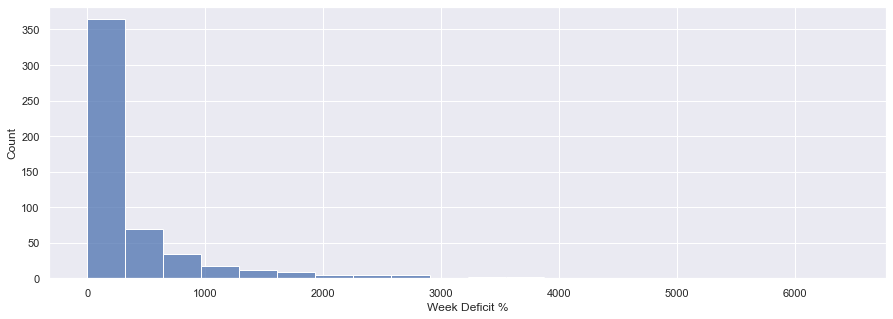

In [119]:
print(len(set(deficit_df["AGEB"])))
sns.histplot(deficit_df["Week Deficit %"], bins = 20)

In [120]:
deficit_df.sort_values(["Week Deficit %"])

,AGEB,Demand,Week Average Supply,Weekend Average Supply,Week Difference,Weekend Difference,Week Deficit %,Weekend Deficit %
1854,5198,4303.842,4300.0,4350.0,-3.842,46.158,0.089349,-1.061103
528,053A,3610.648,3600.0,3600.0,-10.648,-10.648,0.295778,0.295778
658,0681,2719.678,2700.0,2700.0,-19.678,-19.678,0.728815,0.728815
1609,2767,4633.986,4600.0,4600.0,-33.986,-33.986,0.738826,0.738826
1886,5520,3239.410,3200.0,3200.0,-39.410,-39.410,1.231562,1.231562
...,...,...,...,...,...,...,...,...
784,0817,7603.134,200.0,200.0,-7403.134,-7403.134,3701.567000,3701.567000
246,0257,3932.936,100.0,100.0,-3832.936,-3832.936,3832.936000,3832.936000
779,0811,4361.310,100.0,100.0,-4261.310,-4261.310,4261.310000,4261.310000
231,0242,5957.462,100.0,100.0,-5857.462,-5857.462,5857.462000,5857.462000


In [121]:
# Download dataframe with week and weekend deficit to plot it on a map

# deficit_df.to_csv("/content/drive/MyDrive/CYPLAN 257 personal/Project/deficit_df.csv")

In [123]:
cluster1_agebs = df_clusters[df_clusters["cluster"]==0]["AGEB"]
cluster2_agebs = df_clusters[df_clusters["cluster"]==1]["AGEB"]
cluster3_agebs = df_clusters[df_clusters["cluster"]==2]["AGEB"]
cluster4_agebs = df_clusters[df_clusters["cluster"]==3]["AGEB"]

In [124]:
print("Cluster 1",len(deficit_df[deficit_df["AGEB"].isin(cluster1_agebs)]))
print("Cluster 2",len(deficit_df[deficit_df["AGEB"].isin(cluster2_agebs)]))
print("Cluster 3",len(deficit_df[deficit_df["AGEB"].isin(cluster3_agebs)]))
print("Cluster 4",len(deficit_df[deficit_df["AGEB"].isin(cluster4_agebs)]))

Cluster 1 142
Cluster 2 277
Cluster 3 5
Cluster 4 102
